In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
import glob
import aplpy
import sqlite3 
import gzip 
import io
import os

import copy
import json

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

# Set important constants

In [3]:
day_thres = 10 # days
now_jd = Time.now().jd
now_utc = Time.now()

## ***For viewing historical data

In [4]:
offset = 0 #days
now_jd -= offset

# Connect to database

In [5]:
conn = sqlite3.connect('../local/db/sqlite_pid2.db')
cutout_dir = '../local/cutouts/'

# Quick look at objects seen

In [6]:
df = pd.read_sql_query("SELECT * FROM ZTF_objects", conn)
df.columns = ['ztf_object_id', 'SIMBAD_otype', 'ra', 'dec', 'ROSAT_IAU_NAME',
       'SIMBAD_include', 'last_obs', 'seen_flag', 'interest_flag', 'notes']

In [7]:
df.loc[df['SIMBAD_include'] == 1]

ztf_object_id SIMBAD_otype          ra        dec  \
2      ZTF18acctenq          EB*   45.502164  23.766712   
3233   ZTF18abjgxsf          EB*  338.947888  18.311449   
3247   ZTF18abcoxqh            *  336.034493  17.479413   
3261   ZTF19acvugzy          PM*   49.917256  23.909945   
3262   ZTF18acbvqqk            *   47.705896  19.753105   
...             ...          ...         ...        ...   
21268  ZTF18abvuami          Rad  348.351427  39.830426   
21269  ZTF18aaqzpsv            X  265.990829  19.585954   
21280  ZTF18abaqyxp          PM*  324.463106  29.473557   
21283  ZTF18absokgn          No*    5.217312  55.704485   
21285  ZTF19aayuodw          Rad  295.748766 -22.127502   

              ROSAT_IAU_NAME  SIMBAD_include      last_obs  seen_flag  \
2      2RXS J030200.8+234606             1.0  2.459271e+06        NaN   
3233   2RXS J223549.6+181804             1.0  2.459392e+06        NaN   
3247   2RXS J222408.0+172903             1.0  2.459392e+06        NaN   
3261   2RXS J031938.6+235453             1.0  2.459275e+06        NaN   
3262   2RXS J031048.3+194518             1.0           NaN        NaN   
...                      ...             ...           ...        ...   
21268  2RXS J231322.5+394942             1.0  2.459394e+06        0.0   
21269  2RXS J174357.1+193508             1.0  2.459395e+06        0.0   
21280  2RXS J213750.2+292830             1.0  2.459394e+06        0.0   
21283  2RXS J002052.4+554212             1.0  2.459394e+06        0.0   
21285  2RXS J194300.7-220751             1.0  2.459394e+06        0.0   

       interest_flag notes  
2                NaN  None  
3233             NaN  None  
3247             NaN  None  
3261             NaN  None  
3262             NaN  None  
...              ...   ...  
21268            1.0  None  
21269            1.0  None  
21280            1.0  None  
21283            1.0  None  
21285            1.0  None  

[2110 rows x 10 columns]

In [8]:
pd.to_datetime([df['last_obs'].max()], unit='D', origin='julian')

DatetimeIndex(['2021-06-29 11:35:43.995840'], dtype='datetime64[ns]', freq=None)

In [9]:
df['dec'].min()

-29.7110958

# Read lightcurve data

In [10]:
cur = conn.cursor()
cur.execute("SELECT * FROM lightcurves")
dflc = pd.DataFrame(cur.fetchall())
dflc.columns = ['ztf_object_id', 'jd', 'fid', 'magpsf', 'sigmapsf', 'diffmaglim', 'isdiffpos', 'magnr', 'sigmagnr', 'field', 'rcid']
dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']] = dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']].astype(float)
dflc['fid'] = dflc['fid'].astype(int)

## ***If historical, drop all rows taken after "now_jd"

In [11]:
dflc = dflc.loc[(now_jd - dflc['jd']) > 0]

<AxesSubplot:>

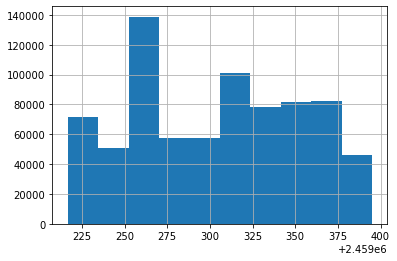

In [12]:
dflc['jd'].hist()

## Drop objects not seen in the past {day_thres} days

In [13]:
df = df.query(f'last_obs > {now_jd - day_thres}')
dflc = dflc.loc[dflc['ztf_object_id'].isin(df['ztf_object_id'])]

# Preprocess lightcurve data

### Impute missing magnr and sigmagnr

In [14]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

0.9176194154757307

In [15]:
len(dflc['field'].dropna()) / len(dflc['field'])

0.803431183211021

In [16]:
len(dflc['rcid'].dropna()) / len(dflc['rcid'])

0.803431183211021

In [17]:
%%time
grp = dflc.groupby(['fid','field','rcid'])
impute_magnr = grp['magnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# print(impute_magnr)
impute_sigmagnr = grp['sigmagnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# print(impute_sigmagnr)

Wall time: 4.01 s


In [18]:
%%time
for idx, grpi in grp:
    w = np.isnan(grpi['magnr'])
    w2 = grpi[w].index
    dflc.loc[w2,'magnr'] = impute_magnr[idx]
    dflc.loc[w2,'sigmagnr'] = impute_sigmagnr[idx]

Wall time: 51.9 s


In [19]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

0.959936268829664

### Calculate DC magnitude

In [20]:
%%time
dflc['sign'] = 2* (dflc['isdiffpos'] == 't') - 1

u = 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf'])
dflc['dc_mag'] = -2.5 * np.log10(u)
dflc['dc_sigmag'] = np.sqrt(
    (10**(-0.4*dflc['magnr'])* dflc['sigmagnr']) **2. + 
    (10**(-0.4*dflc['magpsf']) * dflc['sigmapsf'])**2.) / u
dflc['dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim']))
dflc['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim']))

Wall time: 84 ms


### Drop 0.5% of most uncertain obs

In [21]:
%%time
thres = dflc['dc_sigmag'].quantile(.995)
dflc = dflc.loc[~(dflc['dc_sigmag'] > thres)]

Wall time: 59 ms


### Create new column with ulims subsituting nan dc_mag

In [22]:
%%time
dflc['combined_mag_ulim'] = [dflc.loc[ii, 'dc_mag_ulim'] if pd.isna(dflc.loc[ii, 'dc_mag']) else dflc.loc[ii, 'dc_mag'] for ii in dflc.index]

Wall time: 4.69 s


In [23]:
# dflc['combined_mag_ulim'] = [dflc.loc[ii, 'diffmaglim'] if pd.isna(dflc.loc[ii, 'dc_mag']) else dflc.loc[ii, 'dc_mag'] for ii in dflc.index]

### Exclude objects with otypes we are not interested in

In [24]:
%%time
dflc_interest = dflc[dflc['ztf_object_id'].isin(df.loc[df['SIMBAD_include'] == 1, 'ztf_object_id'])]
dflc_interest

Wall time: 53 ms


ztf_object_id            jd  fid     magpsf  sigmapsf  diffmaglim  \
853     ZTF18abjgxsf  2.459250e+06    2  15.107097  0.080935   16.040958   
854     ZTF18abjgxsf  2.459220e+06    1        NaN       NaN   20.501400   
855     ZTF18abjgxsf  2.459220e+06    2        NaN       NaN   20.235001   
856     ZTF18abjgxsf  2.459220e+06    3        NaN       NaN   18.459400   
857     ZTF18abjgxsf  2.459222e+06    2        NaN       NaN   17.184099   
...              ...           ...  ...        ...       ...         ...   
765358  ZTF18abopeko  2.459395e+06    2  15.370558  0.028929   19.319635   
765364  ZTF18acetlqy  2.459395e+06    2  19.175568  0.168158   19.448547   
765368  ZTF18abnzbxh  2.459395e+06    2  19.290594  0.126247   20.001825   
765431  ZTF18aboegab  2.459395e+06    2  16.124689  0.034522   18.911909   
765444  ZTF18aboegab  2.459395e+06    2  16.058233  0.060549   19.067484   

       isdiffpos      magnr  sigmagnr  field  rcid  sign     dc_mag  \
853            t  13.382000     0.016    NaN   NaN     1  13.180293   
854         None        NaN       NaN    NaN   NaN    -1        NaN   
855         None        NaN       NaN    NaN   NaN    -1        NaN   
856         None        NaN       NaN    NaN   NaN    -1        NaN   
857         None        NaN       NaN    NaN   NaN    -1        NaN   
...          ...        ...       ...    ...   ...   ...        ...   
765358         t  14.393000     0.017  284.0  56.0     1  14.022711   
765364         t  18.092001     0.019  339.0  63.0     1  17.751298   
765368         t  18.266001     0.017  693.0  60.0     1  17.909096   
765431         f  14.870000     0.019  655.0   7.0    -1  15.280559   
765444         f  14.870000     0.019  655.0   7.0    -1  15.312520   

        dc_sigmag  dc_mag_ulim  dc_mag_llim  combined_mag_ulim  
853      0.019101    13.292045    13.480087          13.180293  
854           NaN          NaN          NaN                NaN  
855           NaN          NaN          NaN                NaN  
856           NaN          NaN          NaN                NaN  
857           NaN          NaN          NaN                NaN  
...           ...          ...          ...                ...  
765358   0.014697    14.381445    14.404679          14.022711  
765364   0.047371    17.818333    18.458774          17.751298  
765368   0.037426    18.066106    18.511195          17.909096  
765431   0.031949    14.844072    14.896562          15.280559  
765444   0.041760    14.847498    14.892978          15.312520  

[18063 rows x 17 columns]

In [25]:
dflc_interest[['dc_mag', 'dc_mag_ulim', 'combined_mag_ulim']]

dc_mag  dc_mag_ulim  combined_mag_ulim
853     13.180293    13.292045          13.180293
854           NaN          NaN                NaN
855           NaN          NaN                NaN
856           NaN          NaN                NaN
857           NaN          NaN                NaN
...           ...          ...                ...
765358  14.022711    14.381445          14.022711
765364  17.751298    17.818333          17.751298
765368  17.909096    18.066106          17.909096
765431  15.280559    14.844072          15.280559
765444  15.312520    14.847498          15.312520

[18063 rows x 3 columns]

### Set df index to id and filter, then sort by time

In [26]:
%%time
dflc_interest['utc'] = pd.to_datetime(dflc_interest['jd'], unit='D', origin='julian')
dflc_interest.set_index(['ztf_object_id', 'fid'], inplace=True)
dflc_interest = dflc_interest.sort_values('utc').sort_index()

Wall time: 130 ms


### Get list of ids seen in the past X days

In [27]:
%%time
last_seen = dflc_interest.groupby('ztf_object_id')['jd'].max()
new_sources = last_seen.loc[(now_jd - last_seen) < day_thres].index

Wall time: 1.99 ms


In [28]:
print(f"Number of new sources: {len(new_sources)}")

Number of new sources: 330


### Calculate exponential weighted moving averages
using timescales of 2, 8, and 28 days

In [29]:
%%time

# dflc_interest['ema2'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='2 days', times=x['utc']).mean()).values
dflc_interest['ema8'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='8 days', times=x['utc']).mean()).values
# dflc_interest['ema28'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='28 days', times=x['utc']).mean()).values

Wall time: 1.75 s


In [30]:
%%time

# dflc_interest['combined_ema2'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='2 days', times=x['utc']).mean()).values
dflc_interest['combined_ema8'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='8 days', times=x['utc']).mean()).values
# dflc_interest['combined_ema28'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='28 days', times=x['utc']).mean()).values

Wall time: 2.24 s


### Calculate our metric for outbursting

- Take difference between 8day halflife EWMA and dc_magnitude
- Take the 4 day halflife EWMA of these differences

In [31]:
%%time
dflc_interest['mag_ewm_diff8'] = dflc_interest['dc_mag'] - dflc_interest['ema8']
dflc_interest['mag_ewm_diff8_rolling4'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

Wall time: 1.38 s


In [32]:
%%time
dflc_interest['combined_mag_ewm_diff8'] = dflc_interest['combined_mag_ulim'] - dflc_interest['combined_ema8']
dflc_interest['combined_mag_ewm_diff8_rolling4'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

Wall time: 1.25 s


### Get data for new sources only and time range we care about 

In [33]:
dflc_interest_new = dflc_interest.loc[new_sources]

In [34]:
ndays_thres = 30
dflc_interest_new = dflc_interest_new.loc[(now_jd - dflc_interest_new['jd']) < ndays_thres]

### Sort our data by max abs magnitude of our metric in the past X day

In [35]:
recent = dflc_interest_new.loc[(now_jd - dflc_interest_new['jd']) < day_thres]
order_by_max = recent.groupby("ztf_object_id")['mag_ewm_diff8_rolling4'].apply(lambda x: x.abs().max()).sort_values(ascending=False).index

### Investigate distribution of metric

# Visualize results

In [36]:
from plotting_helpers import plot_dc_lightcurve, plot_dc_lightcurve_lim, mark_seen, show_stamps, plot_cutout, update_value

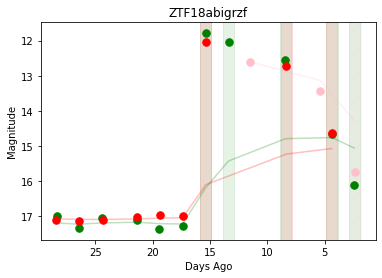

https://lasair.roe.ac.uk/object/ZTF18abigrzf/


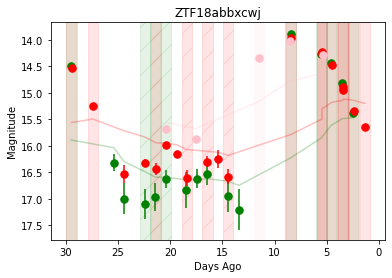

https://lasair.roe.ac.uk/object/ZTF18abbxcwj/


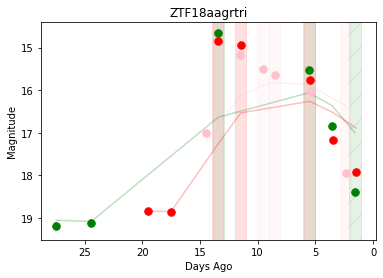

https://lasair.roe.ac.uk/object/ZTF18aagrtri/


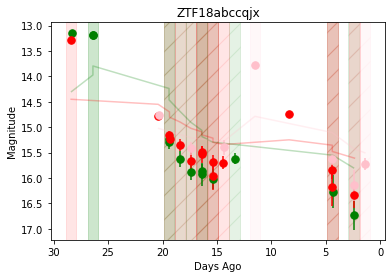

https://lasair.roe.ac.uk/object/ZTF18abccqjx/


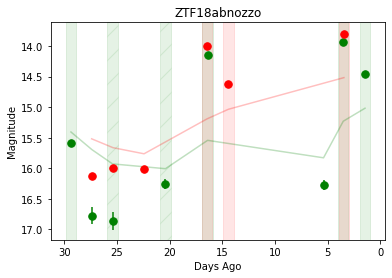

https://lasair.roe.ac.uk/object/ZTF18abnozzo/


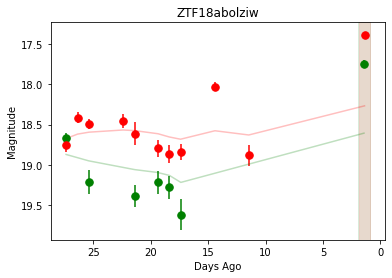

https://lasair.roe.ac.uk/object/ZTF18abolziw/


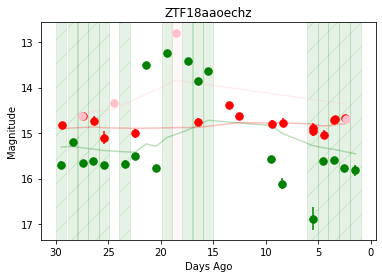

https://lasair.roe.ac.uk/object/ZTF18aaoechz/


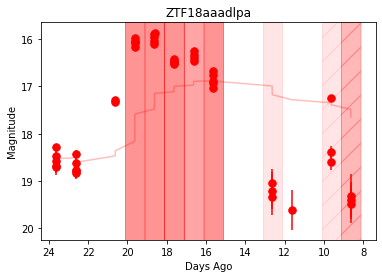

https://lasair.roe.ac.uk/object/ZTF18aaadlpa/


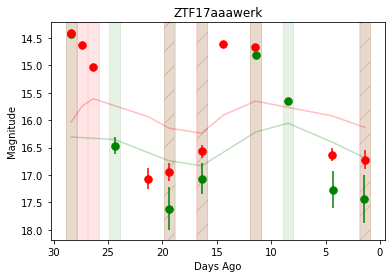

https://lasair.roe.ac.uk/object/ZTF17aaawerk/


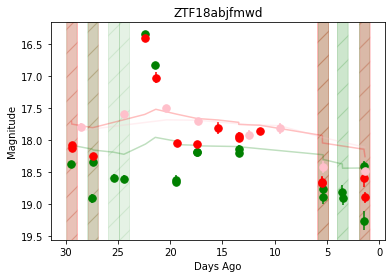

https://lasair.roe.ac.uk/object/ZTF18abjfmwd/


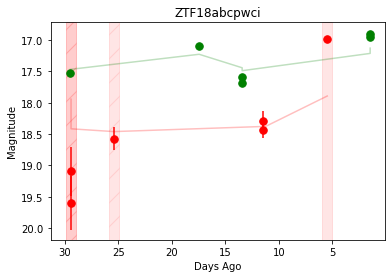

https://lasair.roe.ac.uk/object/ZTF18abcpwci/


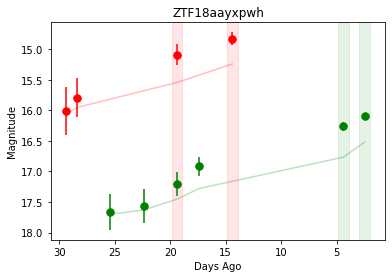

https://lasair.roe.ac.uk/object/ZTF18aayxpwh/


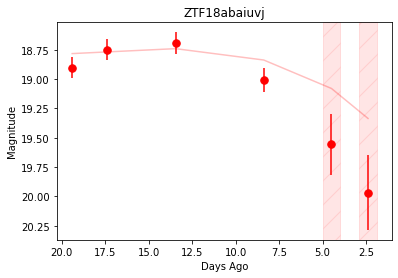

https://lasair.roe.ac.uk/object/ZTF18abaiuvj/


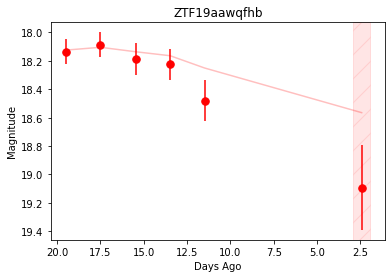

https://lasair.roe.ac.uk/object/ZTF19aawqfhb/


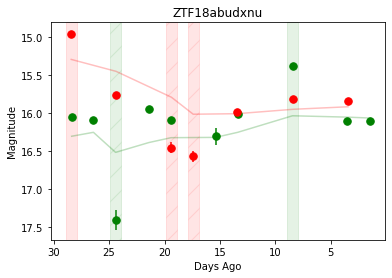

https://lasair.roe.ac.uk/object/ZTF18abudxnu/


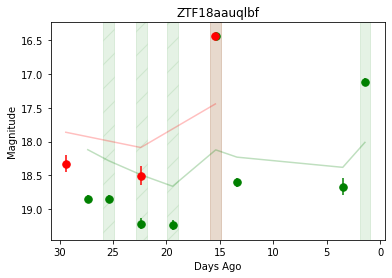

https://lasair.roe.ac.uk/object/ZTF18aauqlbf/


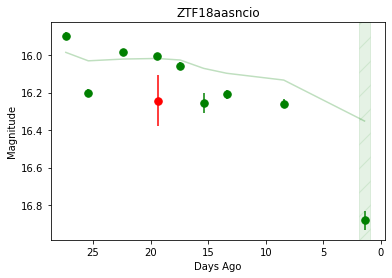

https://lasair.roe.ac.uk/object/ZTF18aasncio/


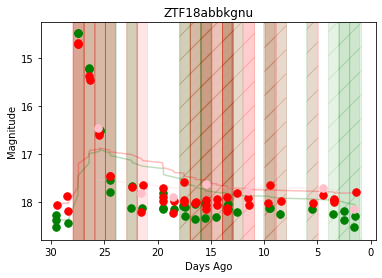

https://lasair.roe.ac.uk/object/ZTF18abbkgnu/


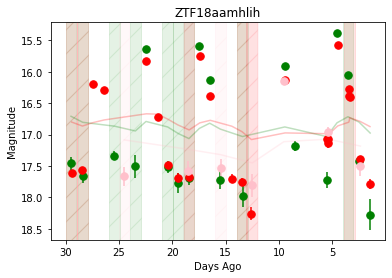

https://lasair.roe.ac.uk/object/ZTF18aamhlih/


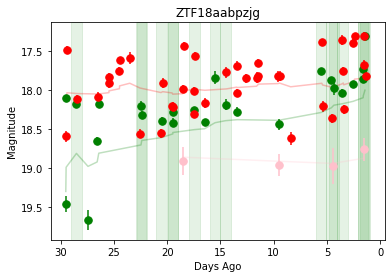

https://lasair.roe.ac.uk/object/ZTF18aabpzjg/


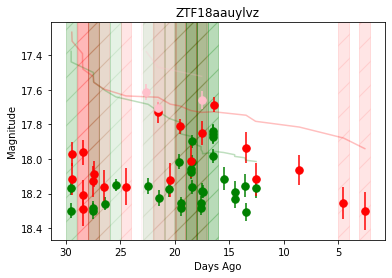

https://lasair.roe.ac.uk/object/ZTF18aauylvz/


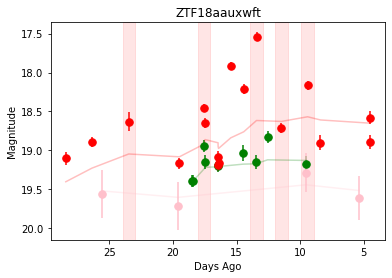

https://lasair.roe.ac.uk/object/ZTF18aauxwft/


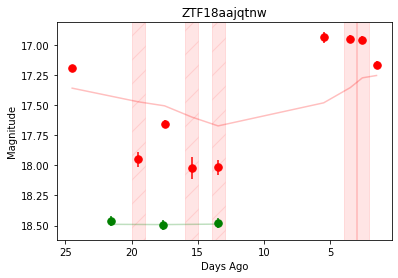

https://lasair.roe.ac.uk/object/ZTF18aajqtnw/


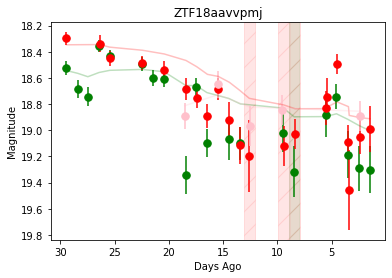

https://lasair.roe.ac.uk/object/ZTF18aavvpmj/


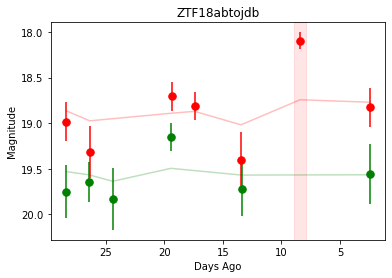

https://lasair.roe.ac.uk/object/ZTF18abtojdb/


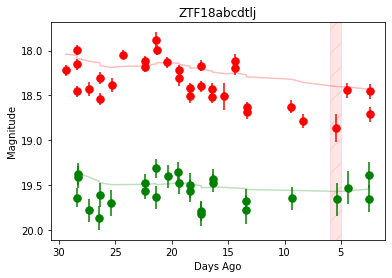

https://lasair.roe.ac.uk/object/ZTF18abcdtlj/


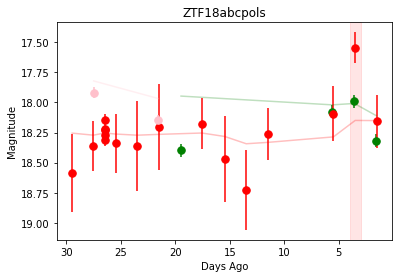

https://lasair.roe.ac.uk/object/ZTF18abcpols/


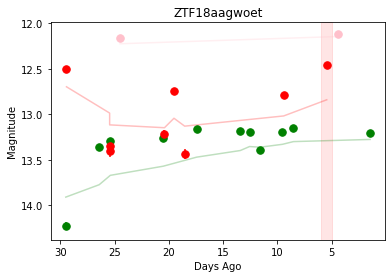

https://lasair.roe.ac.uk/object/ZTF18aagwoet/


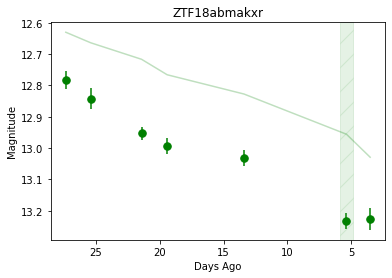

https://lasair.roe.ac.uk/object/ZTF18abmakxr/


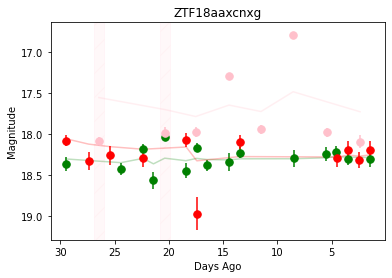

https://lasair.roe.ac.uk/object/ZTF18aaxcnxg/


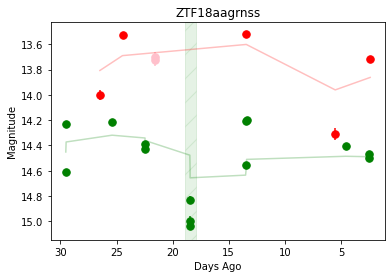

https://lasair.roe.ac.uk/object/ZTF18aagrnss/


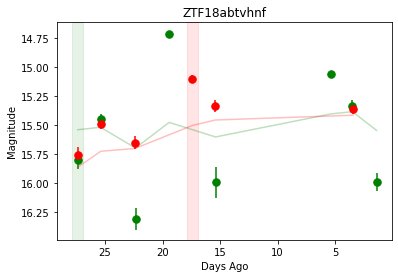

https://lasair.roe.ac.uk/object/ZTF18abtvhnf/


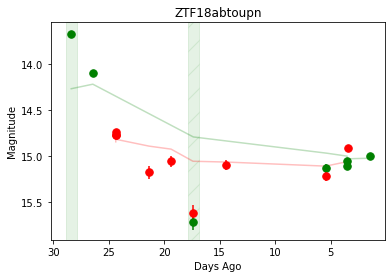

https://lasair.roe.ac.uk/object/ZTF18abtoupn/


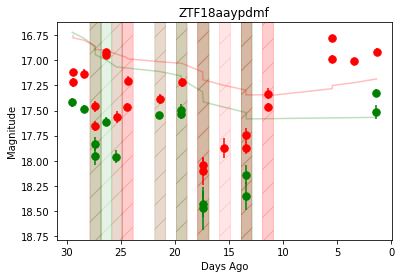

https://lasair.roe.ac.uk/object/ZTF18aaypdmf/


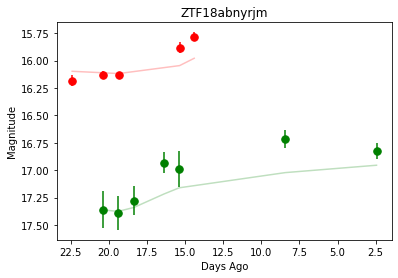

https://lasair.roe.ac.uk/object/ZTF18abnyrjm/


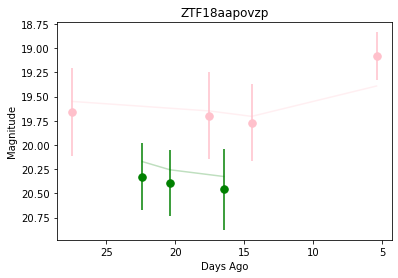

https://lasair.roe.ac.uk/object/ZTF18aapovzp/


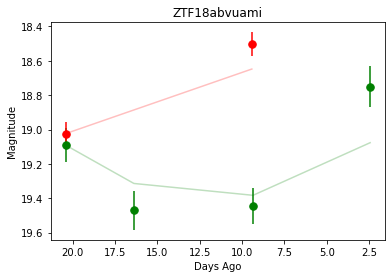

https://lasair.roe.ac.uk/object/ZTF18abvuami/


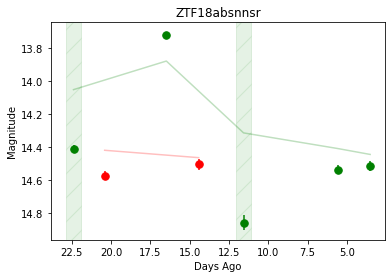

https://lasair.roe.ac.uk/object/ZTF18absnnsr/


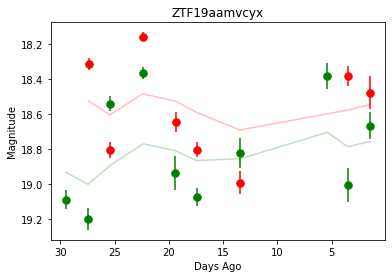

https://lasair.roe.ac.uk/object/ZTF19aamvcyx/


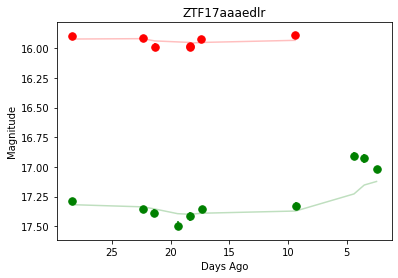

https://lasair.roe.ac.uk/object/ZTF17aaaedlr/


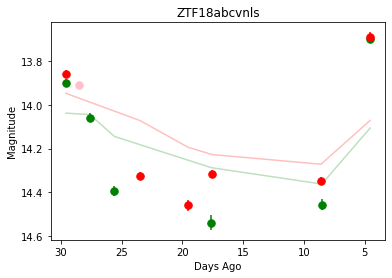

https://lasair.roe.ac.uk/object/ZTF18abcvnls/


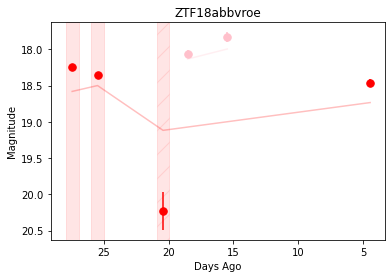

https://lasair.roe.ac.uk/object/ZTF18abbvroe/


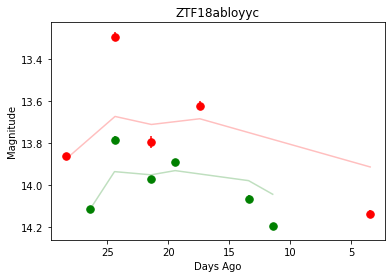

https://lasair.roe.ac.uk/object/ZTF18abloyyc/


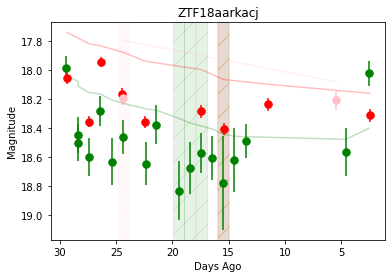

https://lasair.roe.ac.uk/object/ZTF18aarkacj/


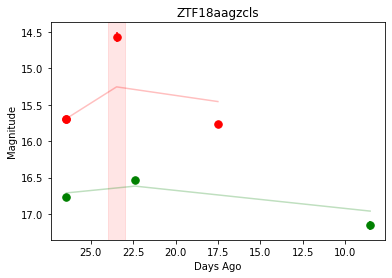

https://lasair.roe.ac.uk/object/ZTF18aagzcls/


In [37]:
for x in order_by_max[:50]:
    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
    if len(sub) > 5:
        _ = plot_dc_lightcurve(sub.reset_index(), x, ema='ema8', ema_diff='mag_ewm_diff8_rolling4', offset=offset)
        print(f'https://lasair.roe.ac.uk/object/{x}/')
        # show_stamps(x)
    # mark_seen(conn, x)


### Do the same, but now include dc_mag_ulim into the rolling calculations

In [38]:
combined_order_by_max = recent.groupby("ztf_object_id")['combined_mag_ewm_diff8_rolling4'].apply(lambda x: x.abs().max()).sort_values(ascending=False).index

In [39]:
len(combined_order_by_max)

330

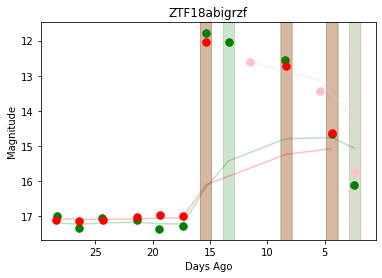

https://lasair.roe.ac.uk/object/ZTF18abigrzf/


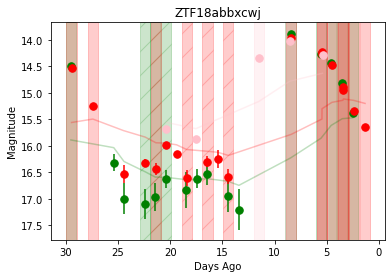

https://lasair.roe.ac.uk/object/ZTF18abbxcwj/


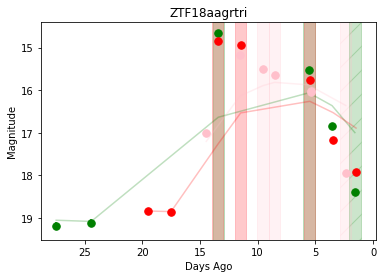

https://lasair.roe.ac.uk/object/ZTF18aagrtri/


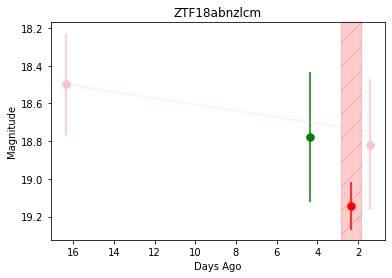

https://lasair.roe.ac.uk/object/ZTF18abnzlcm/


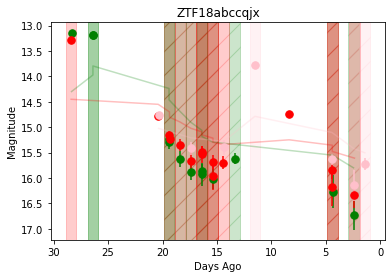

https://lasair.roe.ac.uk/object/ZTF18abccqjx/


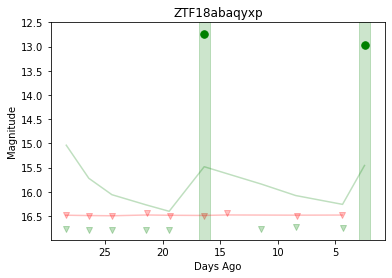

https://lasair.roe.ac.uk/object/ZTF18abaqyxp/


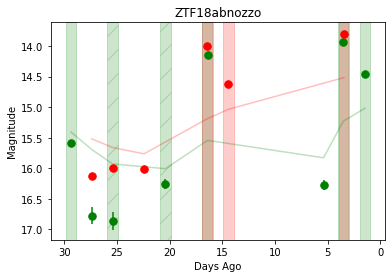

https://lasair.roe.ac.uk/object/ZTF18abnozzo/


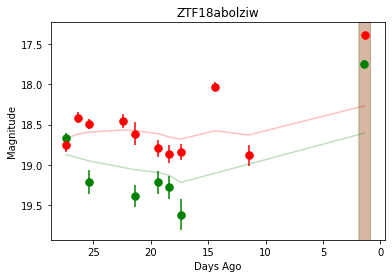

https://lasair.roe.ac.uk/object/ZTF18abolziw/


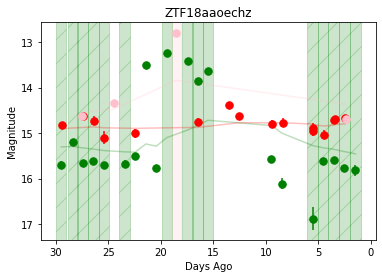

https://lasair.roe.ac.uk/object/ZTF18aaoechz/


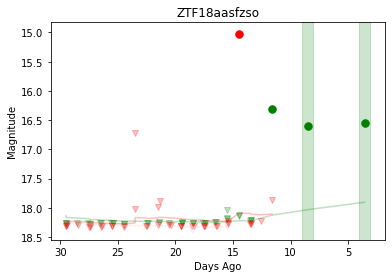

https://lasair.roe.ac.uk/object/ZTF18aasfzso/


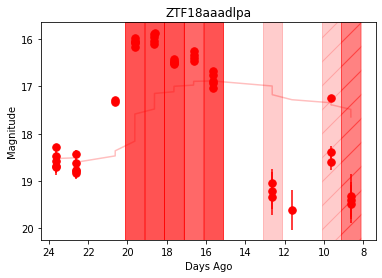

https://lasair.roe.ac.uk/object/ZTF18aaadlpa/


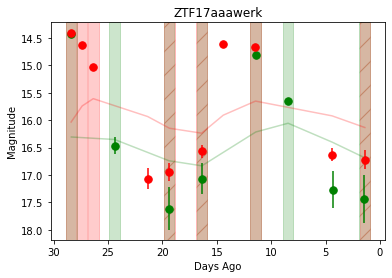

https://lasair.roe.ac.uk/object/ZTF17aaawerk/


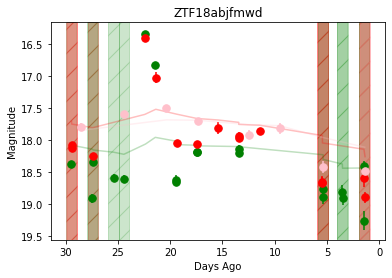

https://lasair.roe.ac.uk/object/ZTF18abjfmwd/


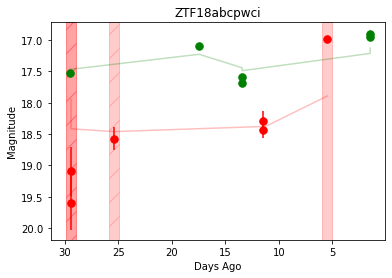

https://lasair.roe.ac.uk/object/ZTF18abcpwci/


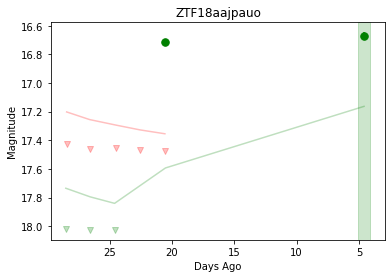

https://lasair.roe.ac.uk/object/ZTF18aajpauo/


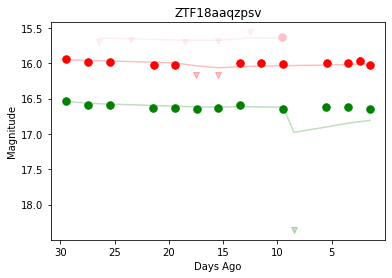

https://lasair.roe.ac.uk/object/ZTF18aaqzpsv/


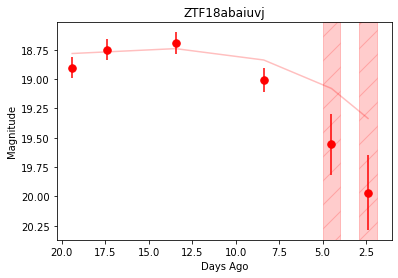

https://lasair.roe.ac.uk/object/ZTF18abaiuvj/


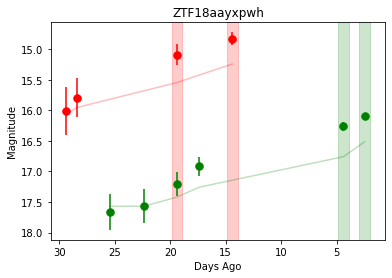

https://lasair.roe.ac.uk/object/ZTF18aayxpwh/


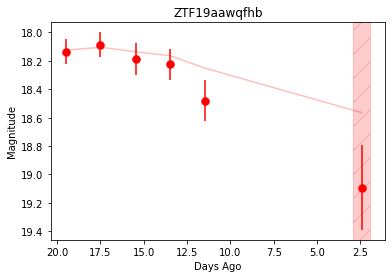

https://lasair.roe.ac.uk/object/ZTF19aawqfhb/


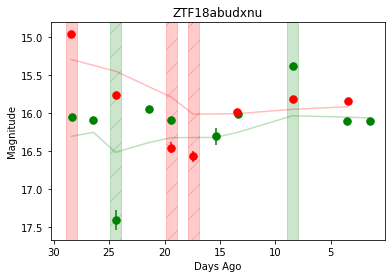

https://lasair.roe.ac.uk/object/ZTF18abudxnu/


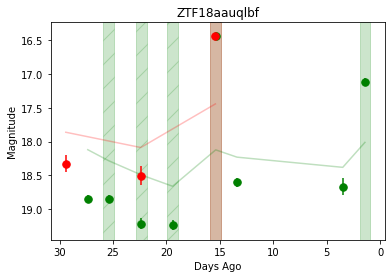

https://lasair.roe.ac.uk/object/ZTF18aauqlbf/


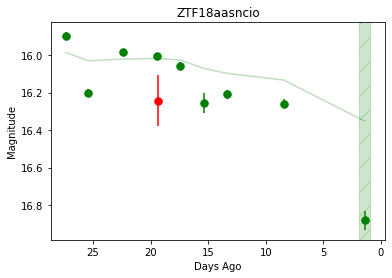

https://lasair.roe.ac.uk/object/ZTF18aasncio/


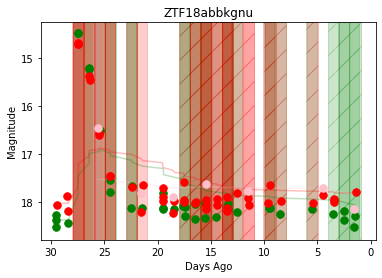

https://lasair.roe.ac.uk/object/ZTF18abbkgnu/


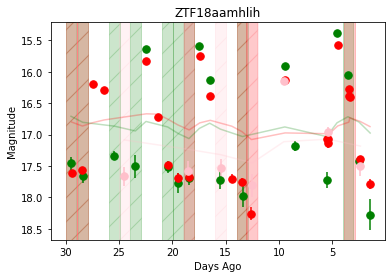

https://lasair.roe.ac.uk/object/ZTF18aamhlih/


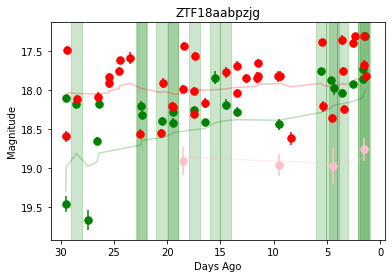

https://lasair.roe.ac.uk/object/ZTF18aabpzjg/


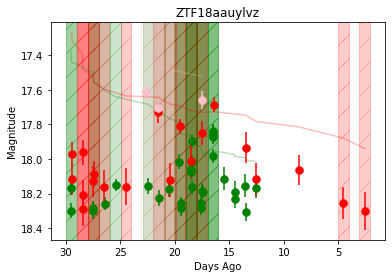

https://lasair.roe.ac.uk/object/ZTF18aauylvz/


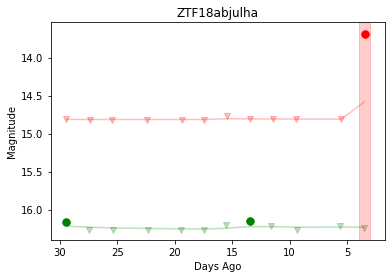

https://lasair.roe.ac.uk/object/ZTF18abjulha/


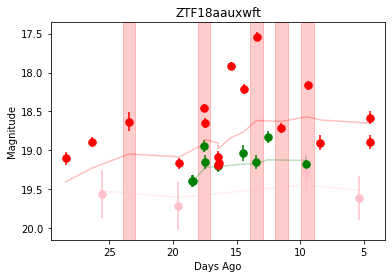

https://lasair.roe.ac.uk/object/ZTF18aauxwft/


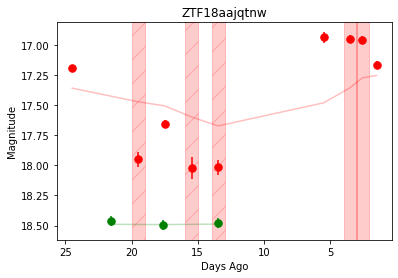

https://lasair.roe.ac.uk/object/ZTF18aajqtnw/


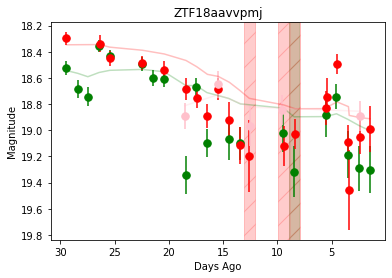

https://lasair.roe.ac.uk/object/ZTF18aavvpmj/


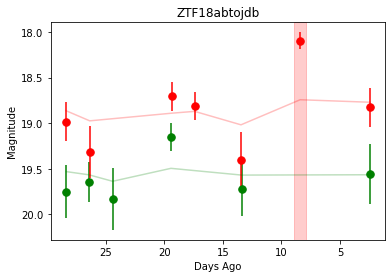

https://lasair.roe.ac.uk/object/ZTF18abtojdb/


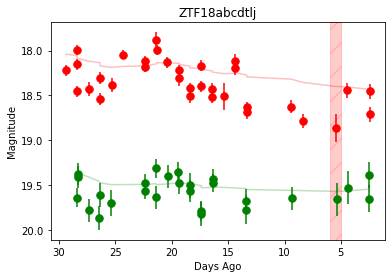

https://lasair.roe.ac.uk/object/ZTF18abcdtlj/


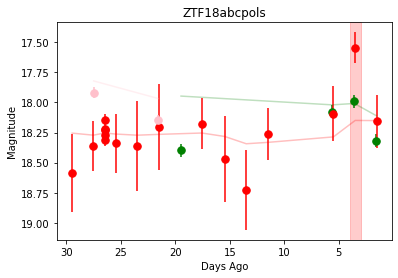

https://lasair.roe.ac.uk/object/ZTF18abcpols/


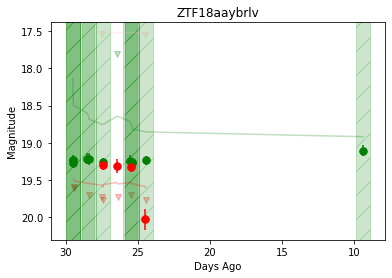

https://lasair.roe.ac.uk/object/ZTF18aaybrlv/


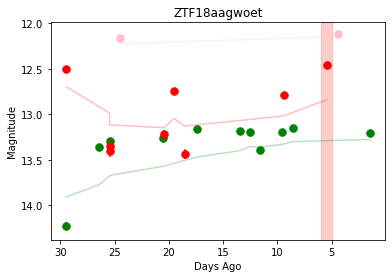

https://lasair.roe.ac.uk/object/ZTF18aagwoet/


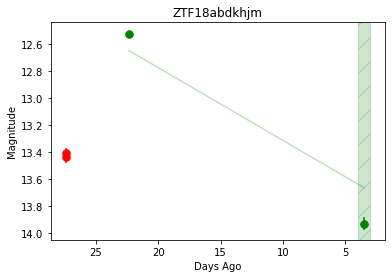

https://lasair.roe.ac.uk/object/ZTF18abdkhjm/


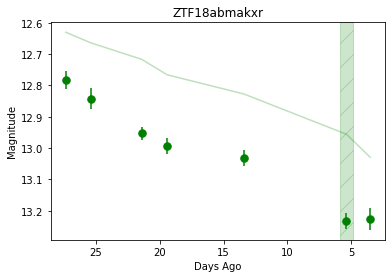

https://lasair.roe.ac.uk/object/ZTF18abmakxr/


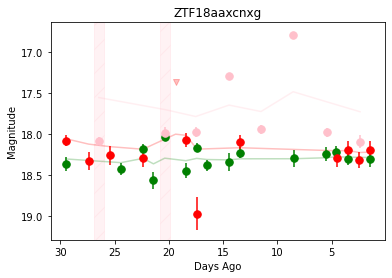

https://lasair.roe.ac.uk/object/ZTF18aaxcnxg/


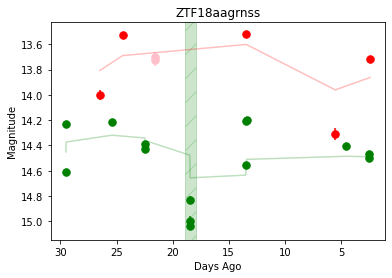

https://lasair.roe.ac.uk/object/ZTF18aagrnss/


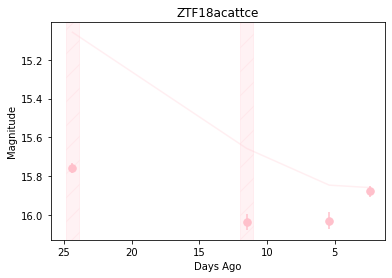

https://lasair.roe.ac.uk/object/ZTF18acattce/


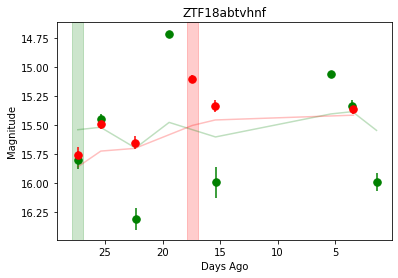

https://lasair.roe.ac.uk/object/ZTF18abtvhnf/


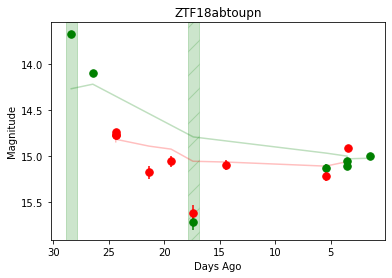

https://lasair.roe.ac.uk/object/ZTF18abtoupn/


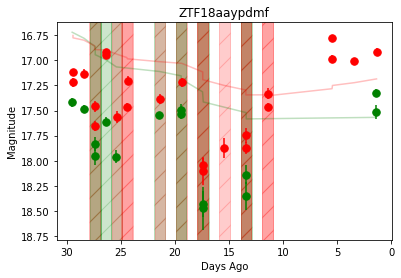

https://lasair.roe.ac.uk/object/ZTF18aaypdmf/


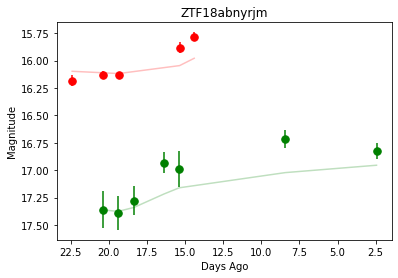

https://lasair.roe.ac.uk/object/ZTF18abnyrjm/


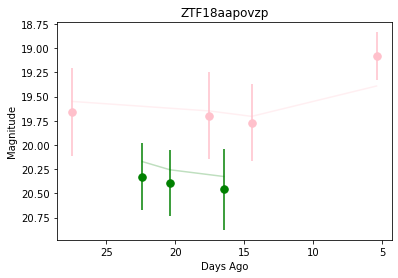

https://lasair.roe.ac.uk/object/ZTF18aapovzp/


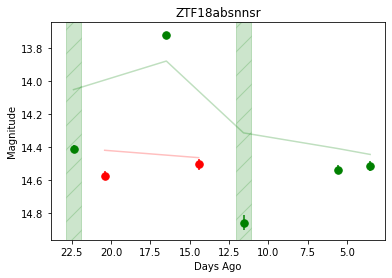

https://lasair.roe.ac.uk/object/ZTF18absnnsr/


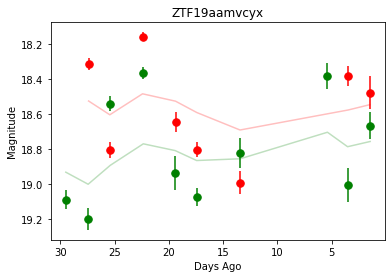

https://lasair.roe.ac.uk/object/ZTF19aamvcyx/


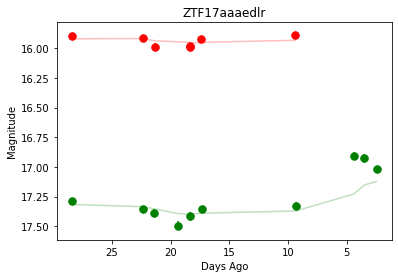

https://lasair.roe.ac.uk/object/ZTF17aaaedlr/


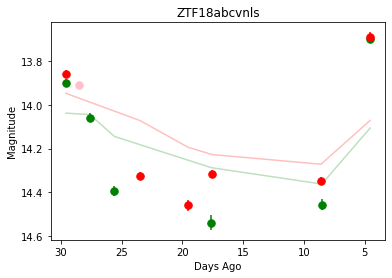

https://lasair.roe.ac.uk/object/ZTF18abcvnls/


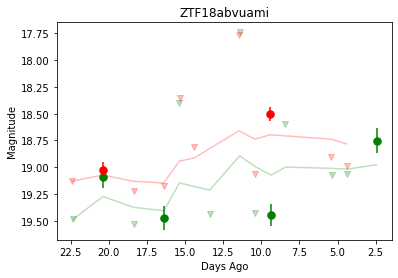

https://lasair.roe.ac.uk/object/ZTF18abvuami/


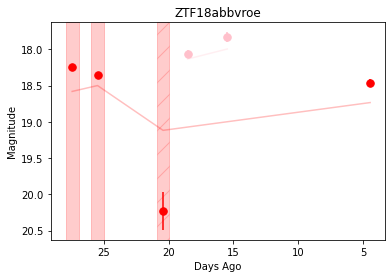

https://lasair.roe.ac.uk/object/ZTF18abbvroe/


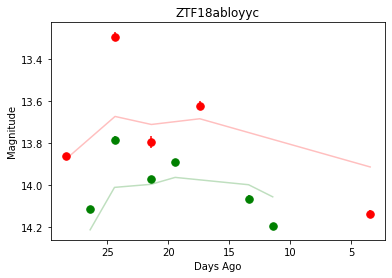

https://lasair.roe.ac.uk/object/ZTF18abloyyc/


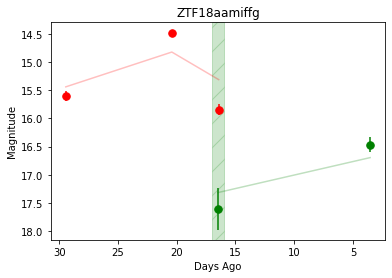

https://lasair.roe.ac.uk/object/ZTF18aamiffg/


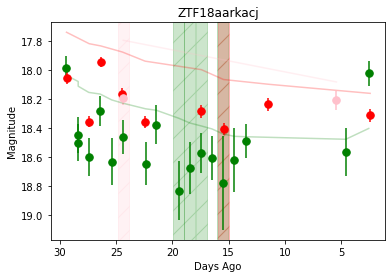

https://lasair.roe.ac.uk/object/ZTF18aarkacj/


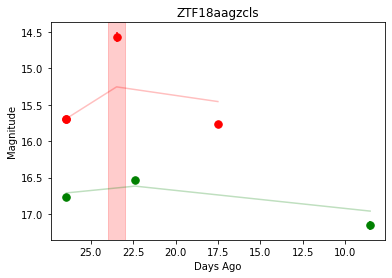

https://lasair.roe.ac.uk/object/ZTF18aagzcls/


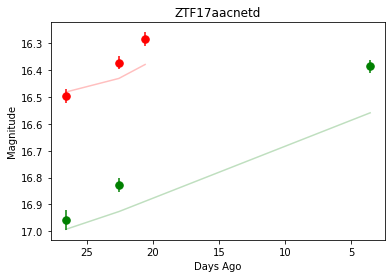

https://lasair.roe.ac.uk/object/ZTF17aacnetd/


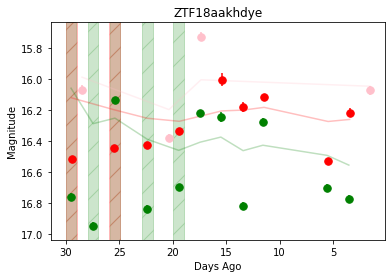

https://lasair.roe.ac.uk/object/ZTF18aakhdye/


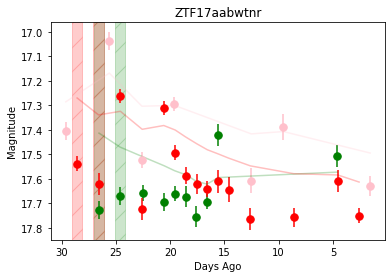

https://lasair.roe.ac.uk/object/ZTF17aabwtnr/


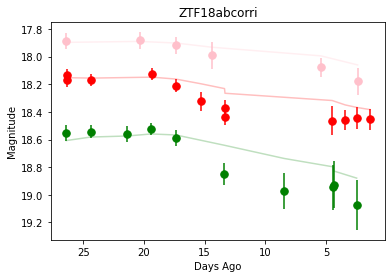

https://lasair.roe.ac.uk/object/ZTF18abcorri/


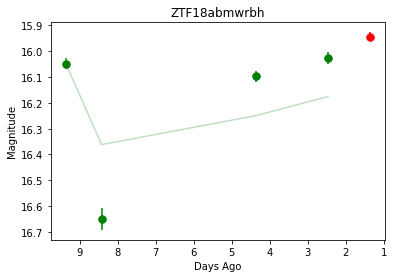

https://lasair.roe.ac.uk/object/ZTF18abmwrbh/


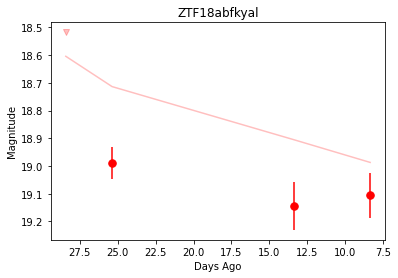

https://lasair.roe.ac.uk/object/ZTF18abfkyal/


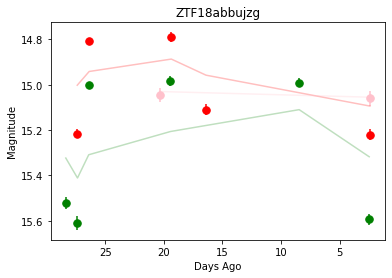

https://lasair.roe.ac.uk/object/ZTF18abbujzg/


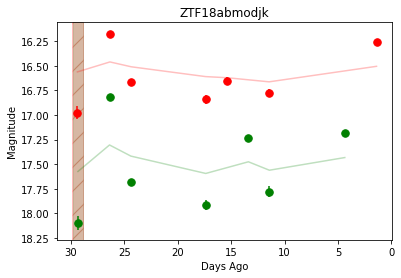

https://lasair.roe.ac.uk/object/ZTF18abmodjk/


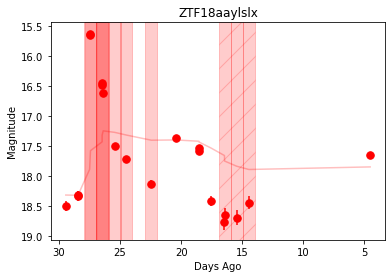

https://lasair.roe.ac.uk/object/ZTF18aaylslx/


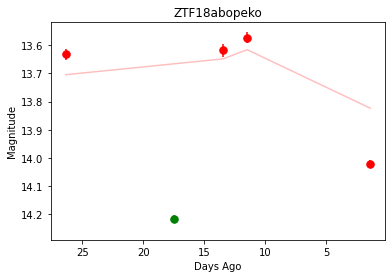

https://lasair.roe.ac.uk/object/ZTF18abopeko/


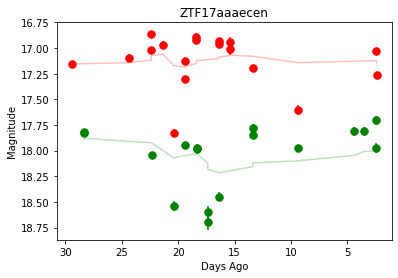

https://lasair.roe.ac.uk/object/ZTF17aaaecen/


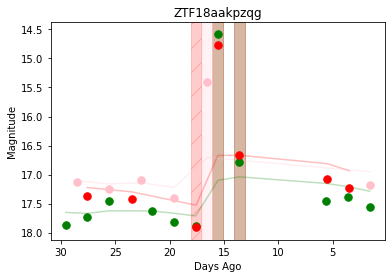

https://lasair.roe.ac.uk/object/ZTF18aakpzqg/


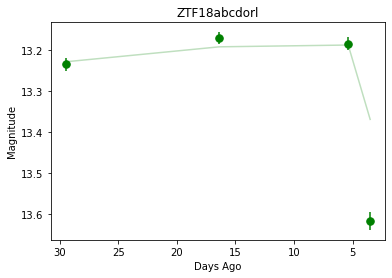

https://lasair.roe.ac.uk/object/ZTF18abcdorl/


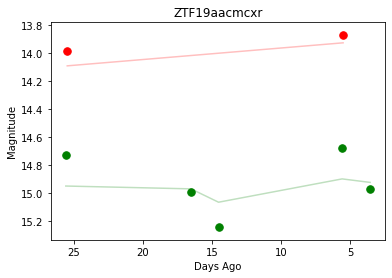

https://lasair.roe.ac.uk/object/ZTF19aacmcxr/


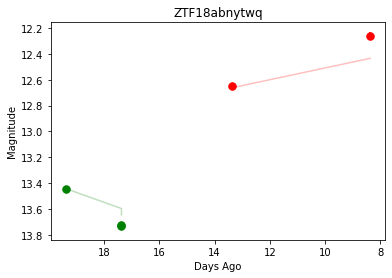

https://lasair.roe.ac.uk/object/ZTF18abnytwq/


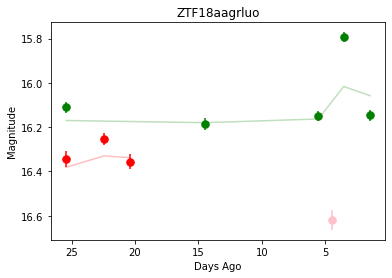

https://lasair.roe.ac.uk/object/ZTF18aagrluo/


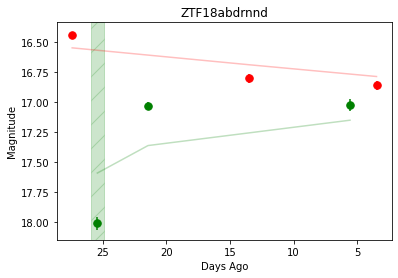

https://lasair.roe.ac.uk/object/ZTF18abdrnnd/


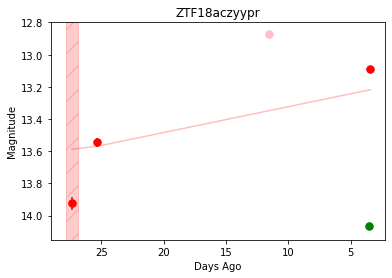

https://lasair.roe.ac.uk/object/ZTF18aczyypr/


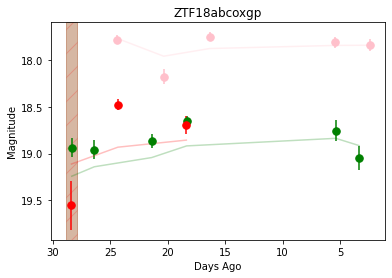

https://lasair.roe.ac.uk/object/ZTF18abcoxgp/


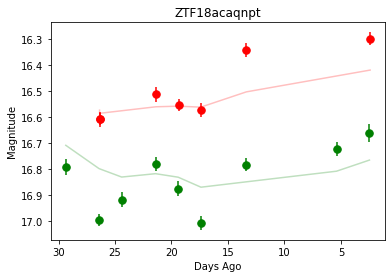

https://lasair.roe.ac.uk/object/ZTF18acaqnpt/


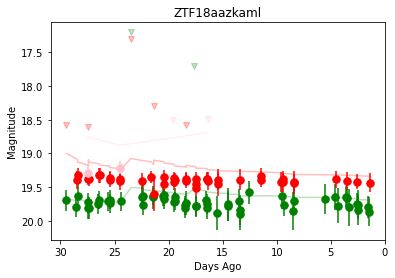

https://lasair.roe.ac.uk/object/ZTF18aazkaml/


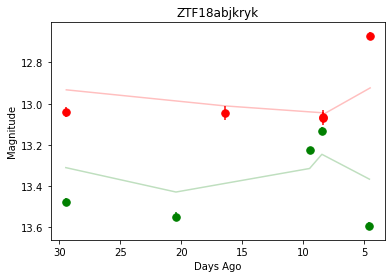

https://lasair.roe.ac.uk/object/ZTF18abjkryk/


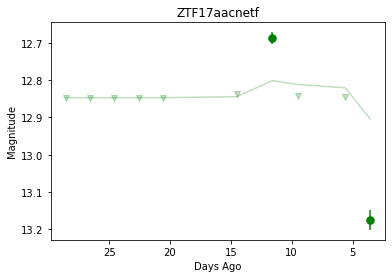

https://lasair.roe.ac.uk/object/ZTF17aacnetf/


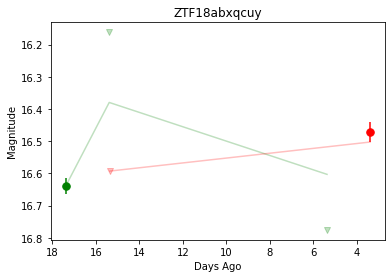

https://lasair.roe.ac.uk/object/ZTF18abxqcuy/


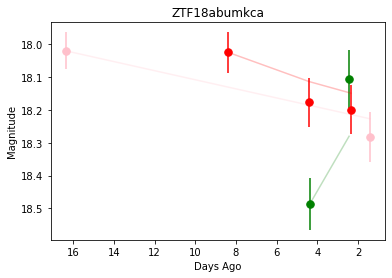

https://lasair.roe.ac.uk/object/ZTF18abumkca/


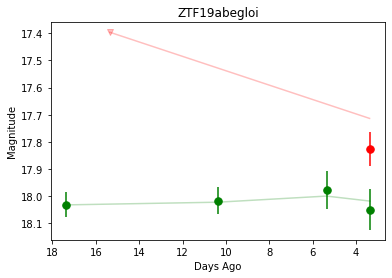

https://lasair.roe.ac.uk/object/ZTF19abegloi/


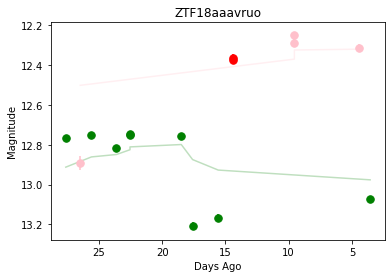

https://lasair.roe.ac.uk/object/ZTF18aaavruo/


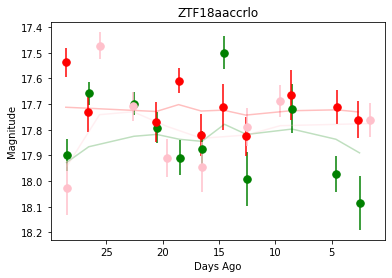

https://lasair.roe.ac.uk/object/ZTF18aaccrlo/


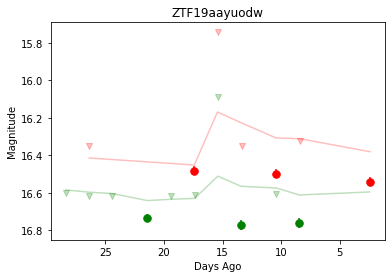

https://lasair.roe.ac.uk/object/ZTF19aayuodw/


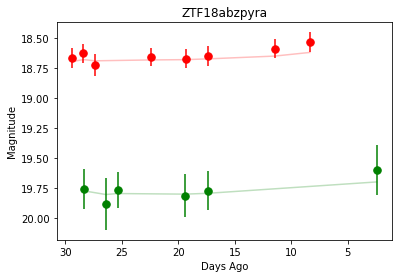

https://lasair.roe.ac.uk/object/ZTF18abzpyra/


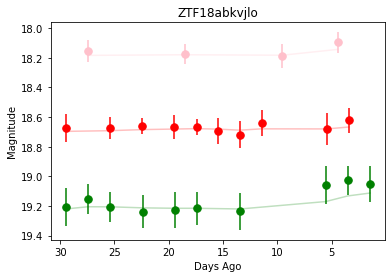

https://lasair.roe.ac.uk/object/ZTF18abkvjlo/


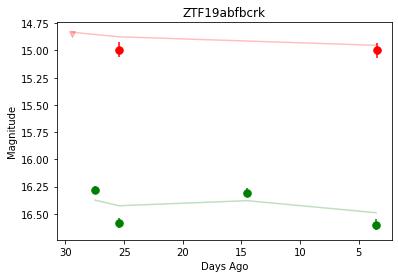

https://lasair.roe.ac.uk/object/ZTF19abfbcrk/


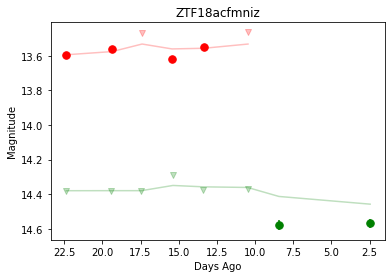

https://lasair.roe.ac.uk/object/ZTF18acfmniz/


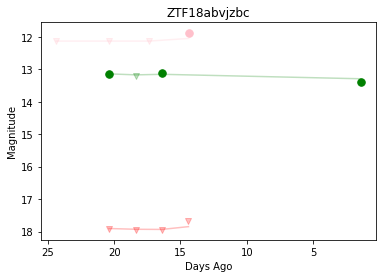

https://lasair.roe.ac.uk/object/ZTF18abvjzbc/


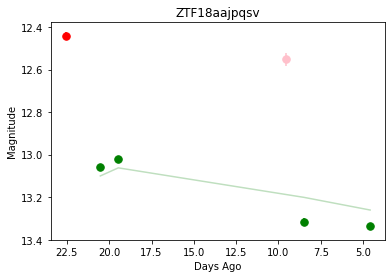

https://lasair.roe.ac.uk/object/ZTF18aajpqsv/


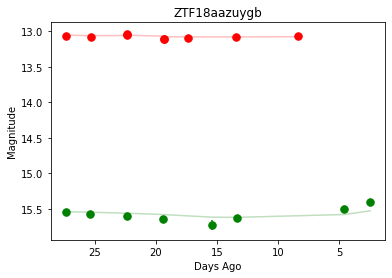

https://lasair.roe.ac.uk/object/ZTF18aazuygb/


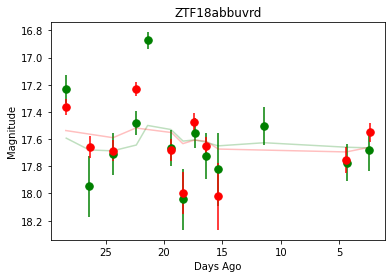

https://lasair.roe.ac.uk/object/ZTF18abbuvrd/


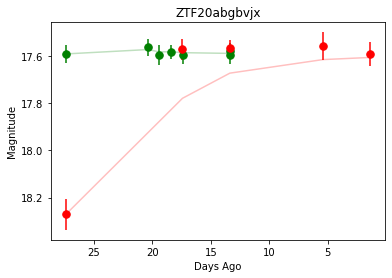

https://lasair.roe.ac.uk/object/ZTF20abgbvjx/


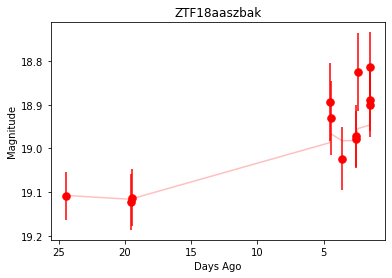

https://lasair.roe.ac.uk/object/ZTF18aaszbak/


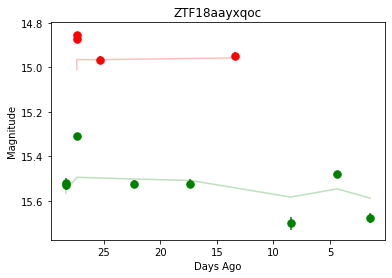

https://lasair.roe.ac.uk/object/ZTF18aayxqoc/


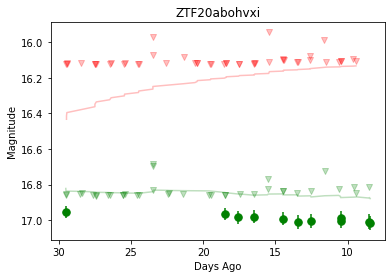

https://lasair.roe.ac.uk/object/ZTF20abohvxi/


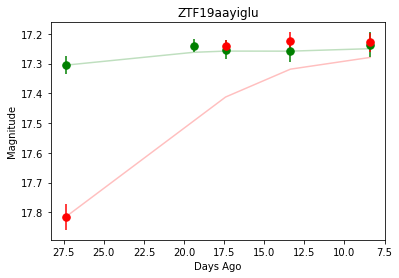

https://lasair.roe.ac.uk/object/ZTF19aayiglu/


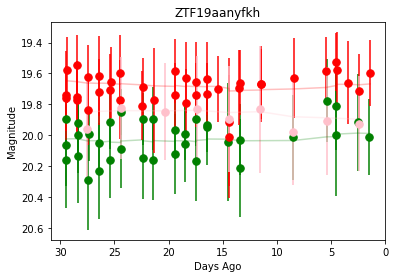

https://lasair.roe.ac.uk/object/ZTF19aanyfkh/


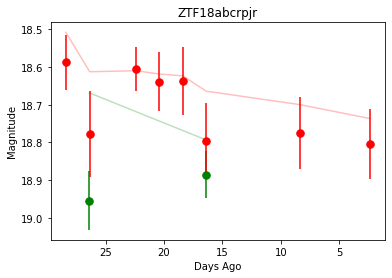

https://lasair.roe.ac.uk/object/ZTF18abcrpjr/


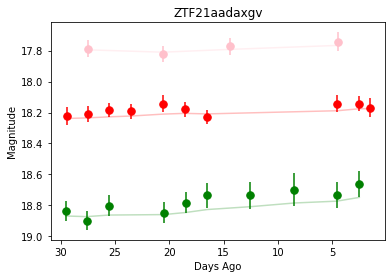

https://lasair.roe.ac.uk/object/ZTF21aadaxgv/


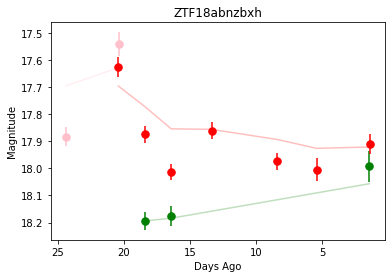

https://lasair.roe.ac.uk/object/ZTF18abnzbxh/


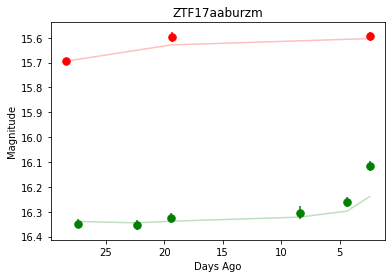

https://lasair.roe.ac.uk/object/ZTF17aaburzm/


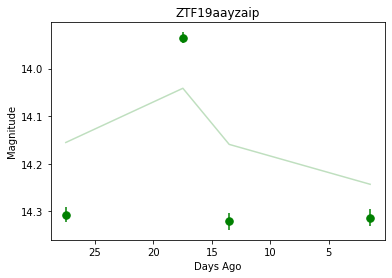

https://lasair.roe.ac.uk/object/ZTF19aayzaip/


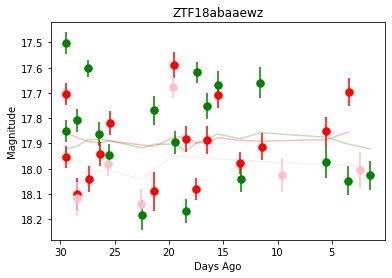

https://lasair.roe.ac.uk/object/ZTF18abaaewz/


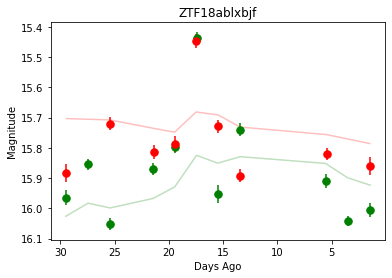

https://lasair.roe.ac.uk/object/ZTF18ablxbjf/


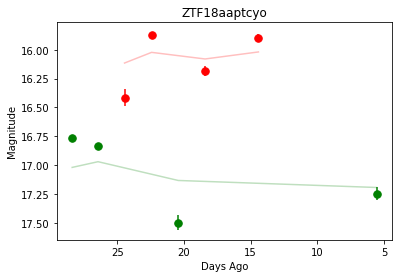

https://lasair.roe.ac.uk/object/ZTF18aaptcyo/


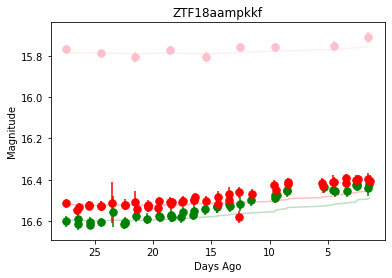

https://lasair.roe.ac.uk/object/ZTF18aampkkf/


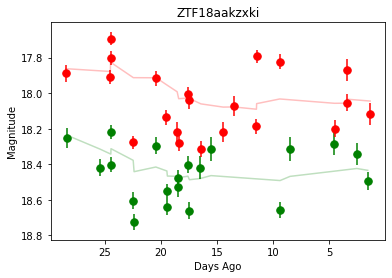

https://lasair.roe.ac.uk/object/ZTF18aakzxki/


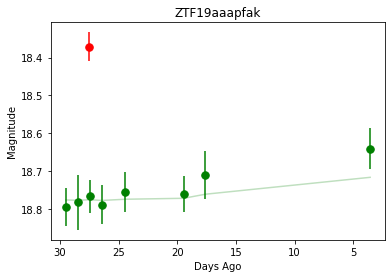

https://lasair.roe.ac.uk/object/ZTF19aaapfak/


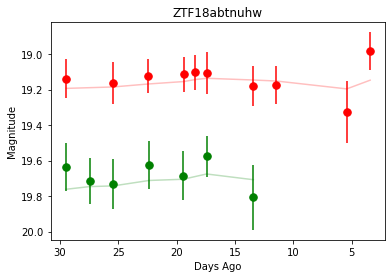

https://lasair.roe.ac.uk/object/ZTF18abtnuhw/


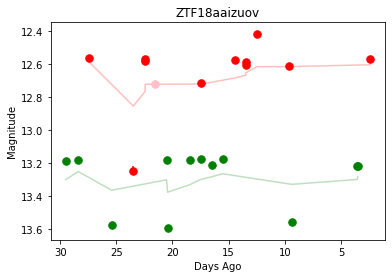

https://lasair.roe.ac.uk/object/ZTF18aaizuov/


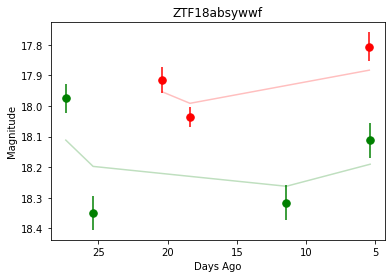

https://lasair.roe.ac.uk/object/ZTF18absywwf/


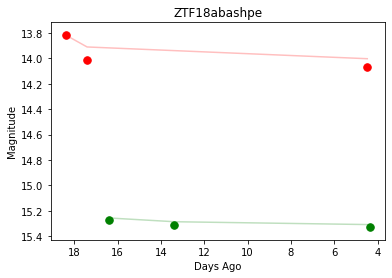

https://lasair.roe.ac.uk/object/ZTF18abashpe/


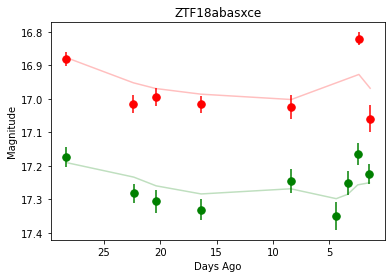

https://lasair.roe.ac.uk/object/ZTF18abasxce/


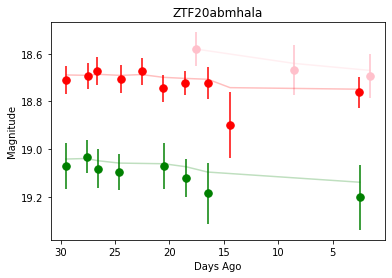

https://lasair.roe.ac.uk/object/ZTF20abmhala/


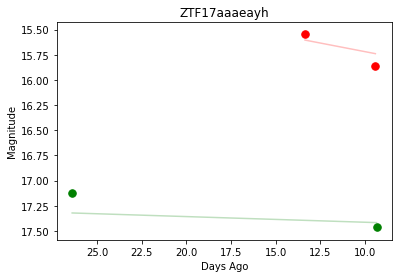

https://lasair.roe.ac.uk/object/ZTF17aaaeayh/


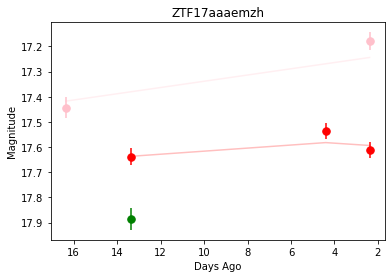

https://lasair.roe.ac.uk/object/ZTF17aaaemzh/


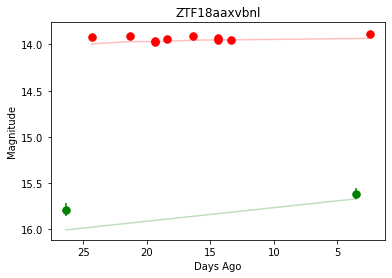

https://lasair.roe.ac.uk/object/ZTF18aaxvbnl/


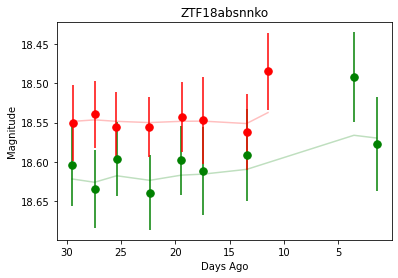

https://lasair.roe.ac.uk/object/ZTF18absnnko/


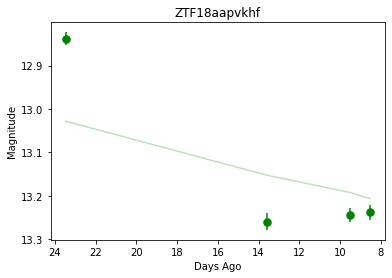

https://lasair.roe.ac.uk/object/ZTF18aapvkhf/


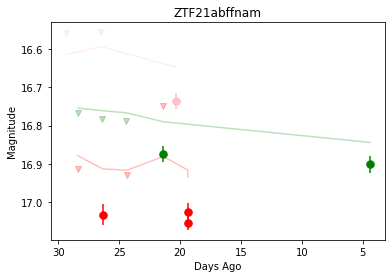

https://lasair.roe.ac.uk/object/ZTF21abffnam/


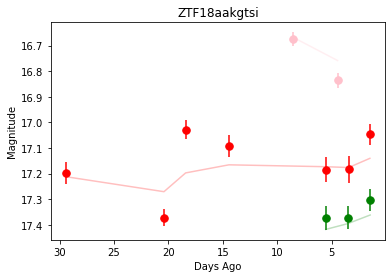

https://lasair.roe.ac.uk/object/ZTF18aakgtsi/


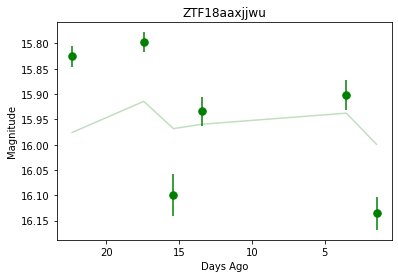

https://lasair.roe.ac.uk/object/ZTF18aaxjjwu/


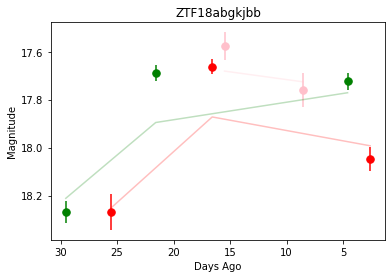

https://lasair.roe.ac.uk/object/ZTF18abgkjbb/


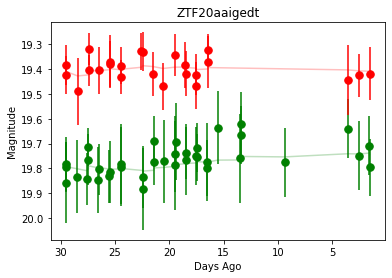

https://lasair.roe.ac.uk/object/ZTF20aaigedt/


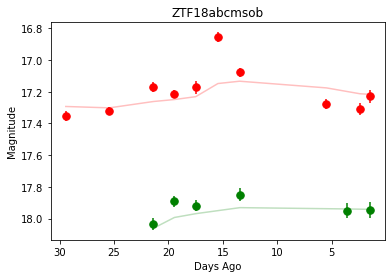

https://lasair.roe.ac.uk/object/ZTF18abcmsob/


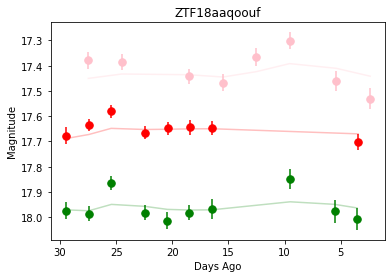

https://lasair.roe.ac.uk/object/ZTF18aaqoouf/


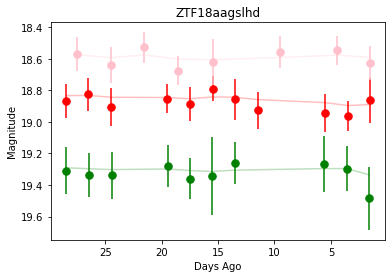

https://lasair.roe.ac.uk/object/ZTF18aagslhd/


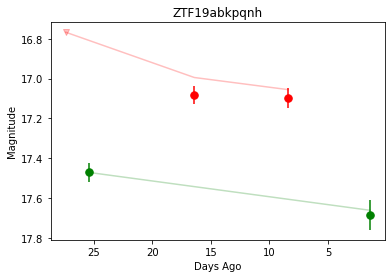

https://lasair.roe.ac.uk/object/ZTF19abkpqnh/


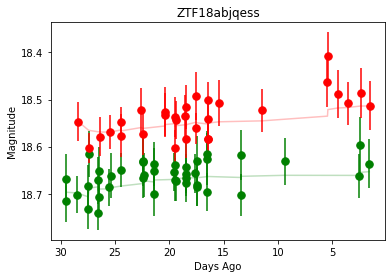

https://lasair.roe.ac.uk/object/ZTF18abjqess/


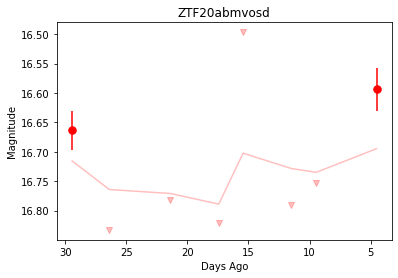

https://lasair.roe.ac.uk/object/ZTF20abmvosd/


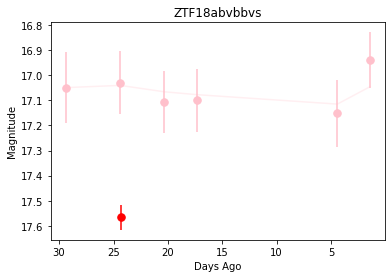

https://lasair.roe.ac.uk/object/ZTF18abvbbvs/


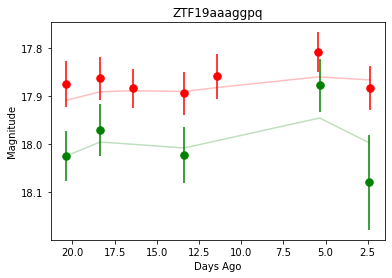

https://lasair.roe.ac.uk/object/ZTF19aaaggpq/


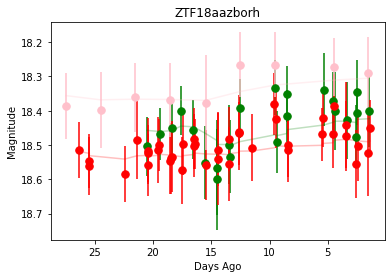

https://lasair.roe.ac.uk/object/ZTF18aazborh/


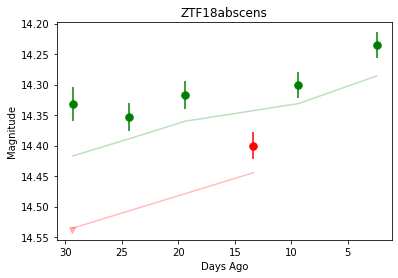

https://lasair.roe.ac.uk/object/ZTF18abscens/


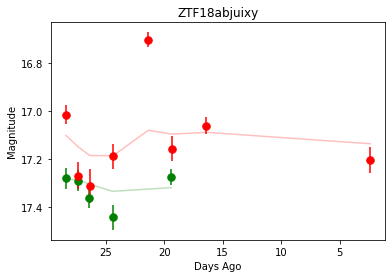

https://lasair.roe.ac.uk/object/ZTF18abjuixy/


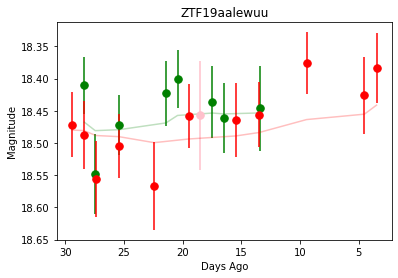

https://lasair.roe.ac.uk/object/ZTF19aalewuu/


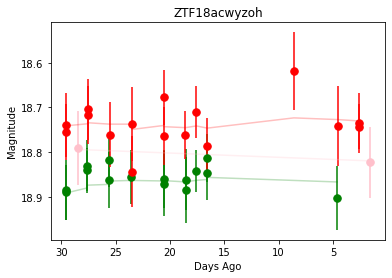

https://lasair.roe.ac.uk/object/ZTF18acwyzoh/


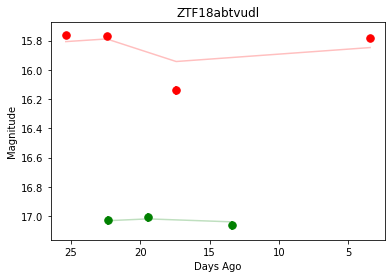

https://lasair.roe.ac.uk/object/ZTF18abtvudl/


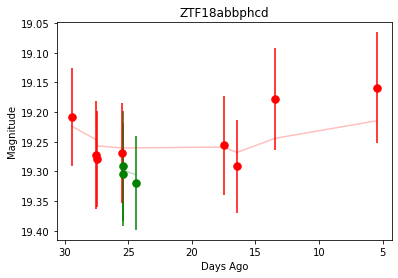

https://lasair.roe.ac.uk/object/ZTF18abbphcd/


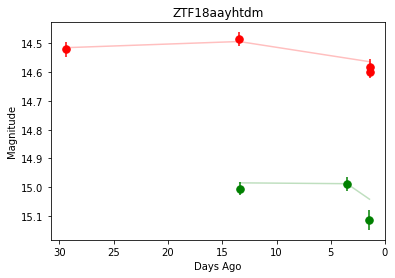

https://lasair.roe.ac.uk/object/ZTF18aayhtdm/


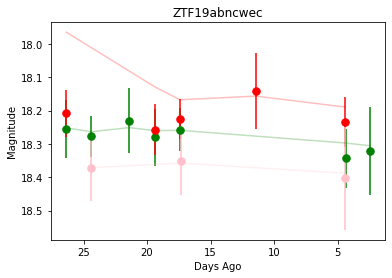

https://lasair.roe.ac.uk/object/ZTF19abncwec/


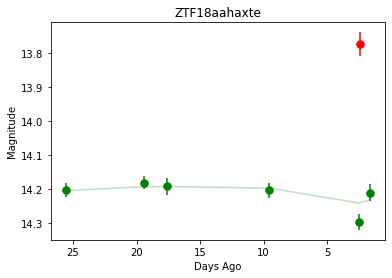

https://lasair.roe.ac.uk/object/ZTF18aahaxte/


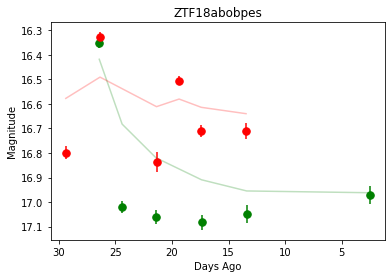

https://lasair.roe.ac.uk/object/ZTF18abobpes/


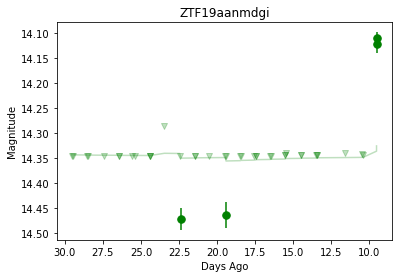

https://lasair.roe.ac.uk/object/ZTF19aanmdgi/


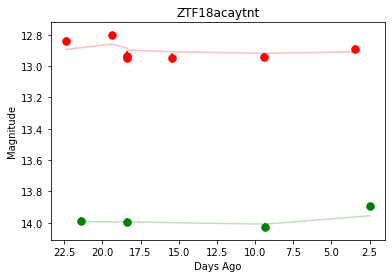

https://lasair.roe.ac.uk/object/ZTF18acaytnt/


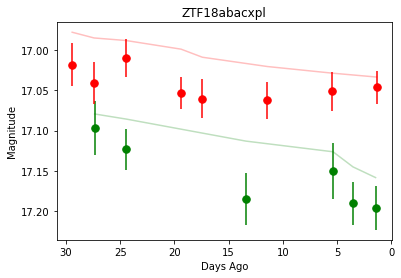

https://lasair.roe.ac.uk/object/ZTF18abacxpl/


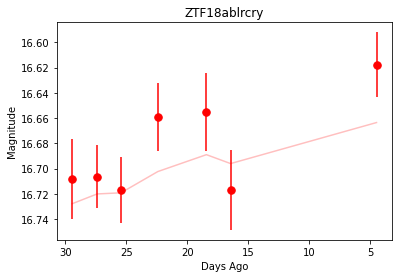

https://lasair.roe.ac.uk/object/ZTF18ablrcry/


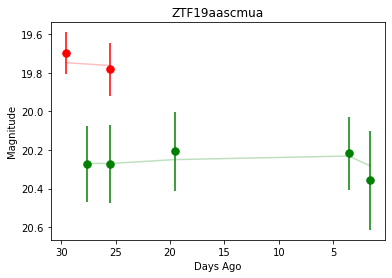

https://lasair.roe.ac.uk/object/ZTF19aascmua/


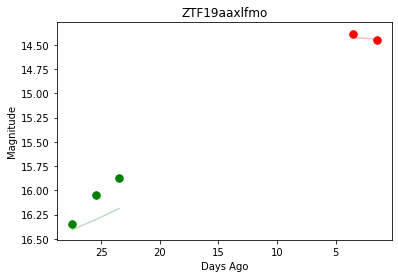

https://lasair.roe.ac.uk/object/ZTF19aaxlfmo/


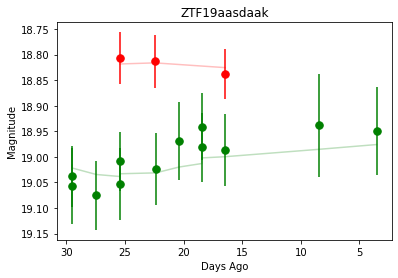

https://lasair.roe.ac.uk/object/ZTF19aasdaak/


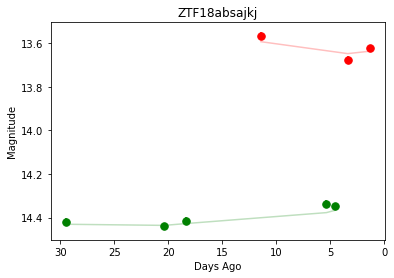

https://lasair.roe.ac.uk/object/ZTF18absajkj/


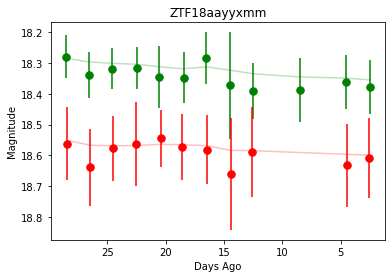

https://lasair.roe.ac.uk/object/ZTF18aayyxmm/


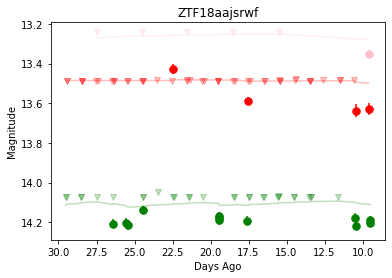

https://lasair.roe.ac.uk/object/ZTF18aajsrwf/


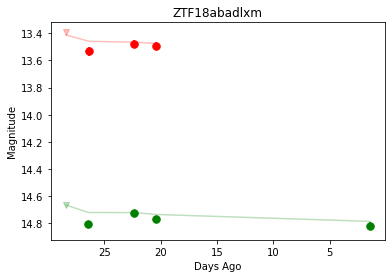

https://lasair.roe.ac.uk/object/ZTF18abadlxm/


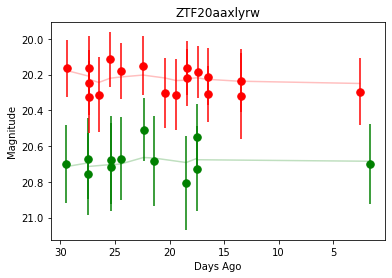

https://lasair.roe.ac.uk/object/ZTF20aaxlyrw/


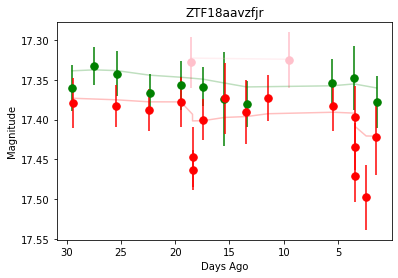

https://lasair.roe.ac.uk/object/ZTF18aavzfjr/


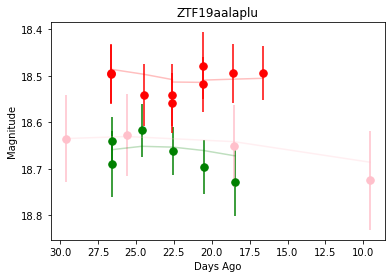

https://lasair.roe.ac.uk/object/ZTF19aalaplu/


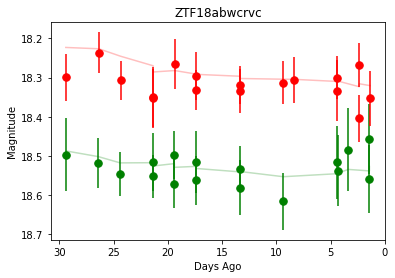

https://lasair.roe.ac.uk/object/ZTF18abwcrvc/


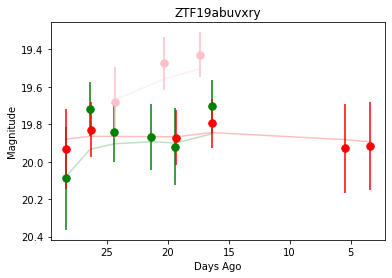

https://lasair.roe.ac.uk/object/ZTF19abuvxry/


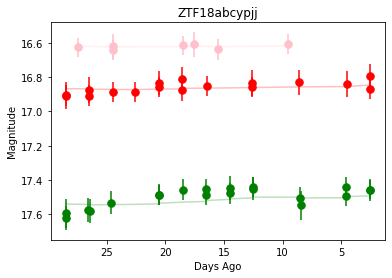

https://lasair.roe.ac.uk/object/ZTF18abcypjj/


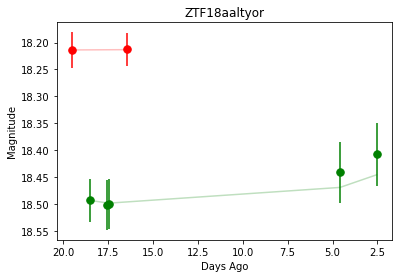

https://lasair.roe.ac.uk/object/ZTF18aaltyor/


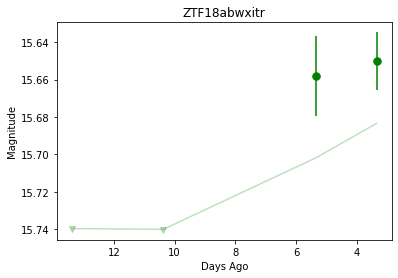

https://lasair.roe.ac.uk/object/ZTF18abwxitr/


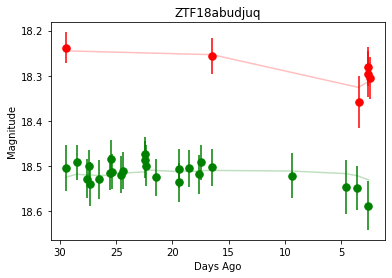

https://lasair.roe.ac.uk/object/ZTF18abudjuq/


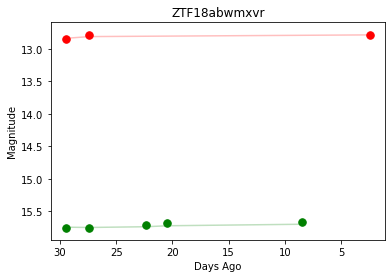

https://lasair.roe.ac.uk/object/ZTF18abwmxvr/


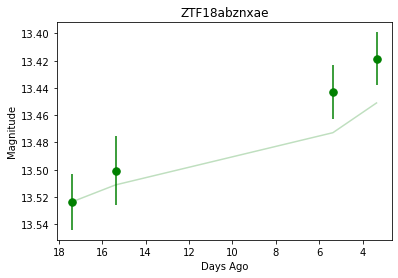

https://lasair.roe.ac.uk/object/ZTF18abznxae/


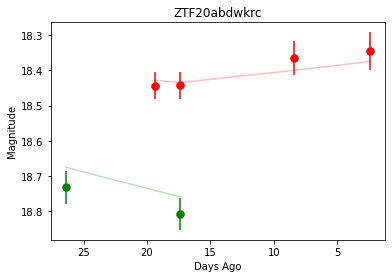

https://lasair.roe.ac.uk/object/ZTF20abdwkrc/


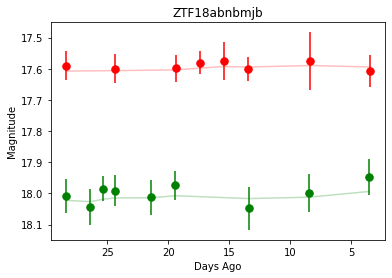

https://lasair.roe.ac.uk/object/ZTF18abnbmjb/


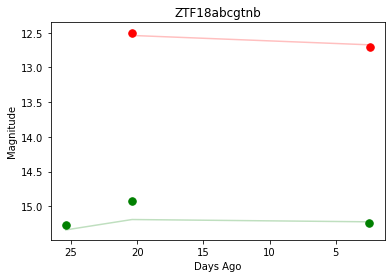

https://lasair.roe.ac.uk/object/ZTF18abcgtnb/


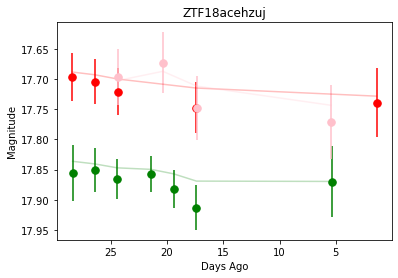

https://lasair.roe.ac.uk/object/ZTF18acehzuj/


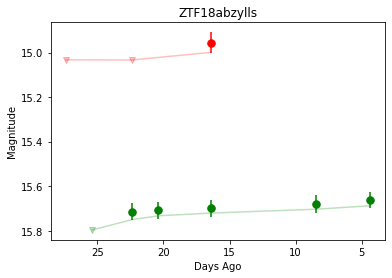

https://lasair.roe.ac.uk/object/ZTF18abzylls/


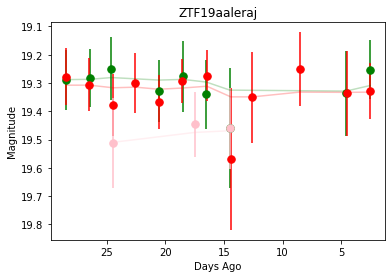

https://lasair.roe.ac.uk/object/ZTF19aaleraj/


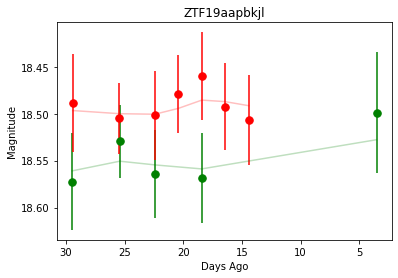

https://lasair.roe.ac.uk/object/ZTF19aapbkjl/


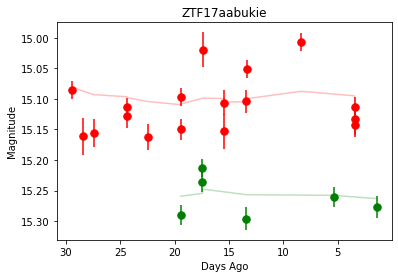

https://lasair.roe.ac.uk/object/ZTF17aabukie/


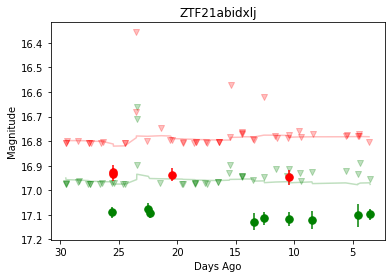

https://lasair.roe.ac.uk/object/ZTF21abidxlj/


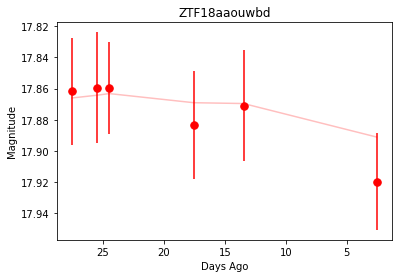

https://lasair.roe.ac.uk/object/ZTF18aaouwbd/


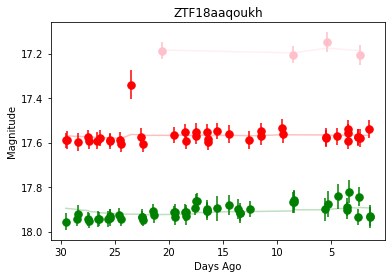

https://lasair.roe.ac.uk/object/ZTF18aaqoukh/


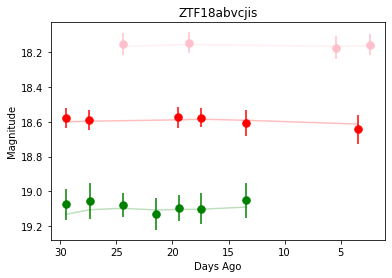

https://lasair.roe.ac.uk/object/ZTF18abvcjis/


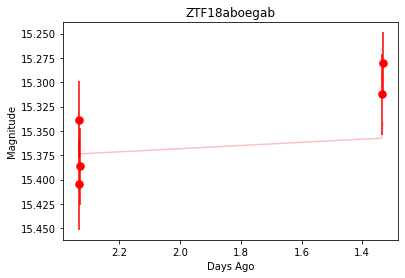

https://lasair.roe.ac.uk/object/ZTF18aboegab/


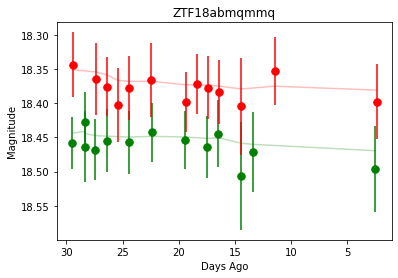

https://lasair.roe.ac.uk/object/ZTF18abmqmmq/


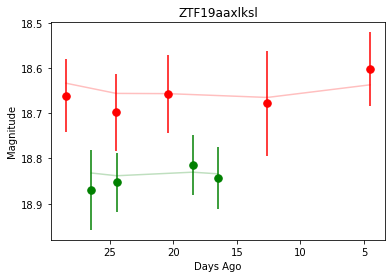

https://lasair.roe.ac.uk/object/ZTF19aaxlksl/


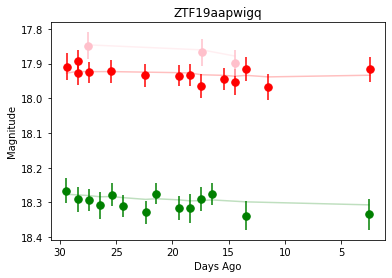

https://lasair.roe.ac.uk/object/ZTF19aapwigq/


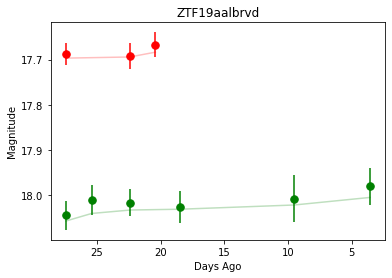

https://lasair.roe.ac.uk/object/ZTF19aalbrvd/


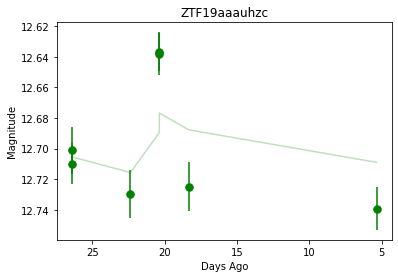

https://lasair.roe.ac.uk/object/ZTF19aaauhzc/


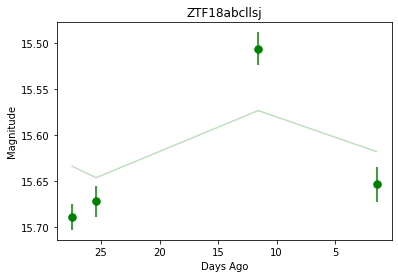

https://lasair.roe.ac.uk/object/ZTF18abcllsj/


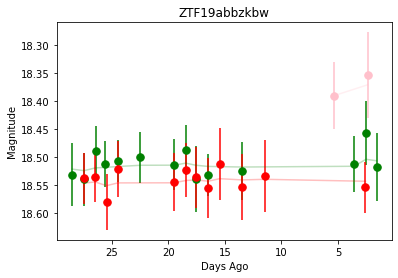

https://lasair.roe.ac.uk/object/ZTF19abbzkbw/


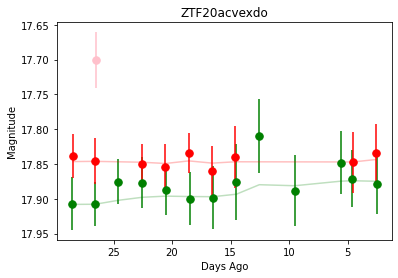

https://lasair.roe.ac.uk/object/ZTF20acvexdo/


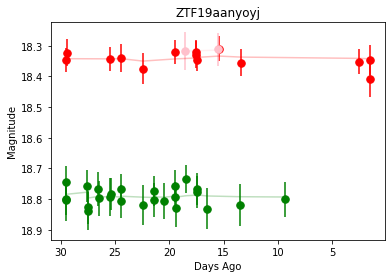

https://lasair.roe.ac.uk/object/ZTF19aanyoyj/


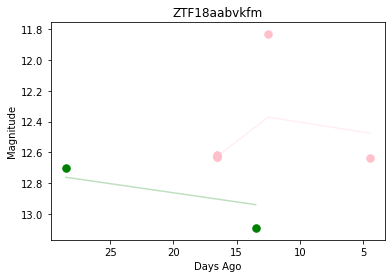

https://lasair.roe.ac.uk/object/ZTF18aabvkfm/


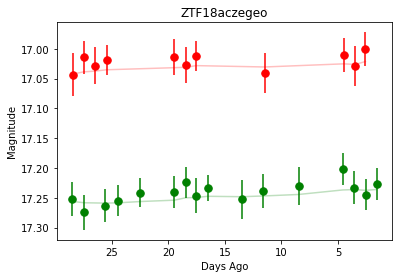

https://lasair.roe.ac.uk/object/ZTF18aczegeo/


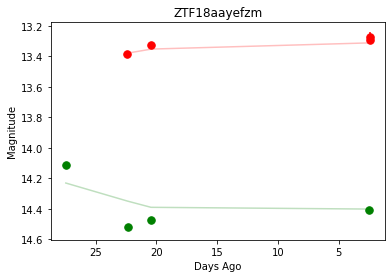

https://lasair.roe.ac.uk/object/ZTF18aayefzm/


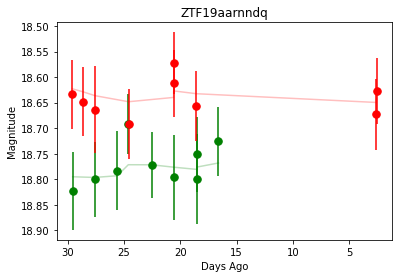

https://lasair.roe.ac.uk/object/ZTF19aarnndq/


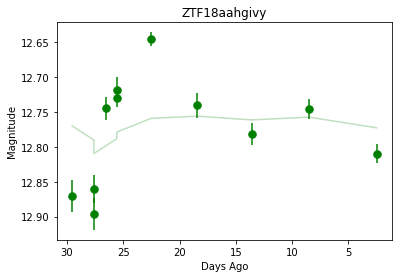

https://lasair.roe.ac.uk/object/ZTF18aahgivy/


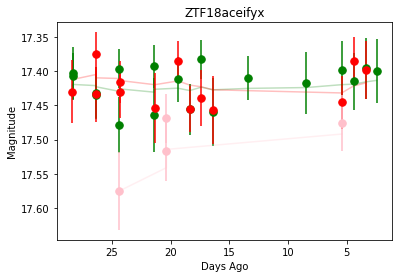

https://lasair.roe.ac.uk/object/ZTF18aceifyx/


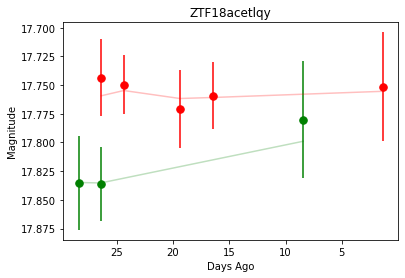

https://lasair.roe.ac.uk/object/ZTF18acetlqy/


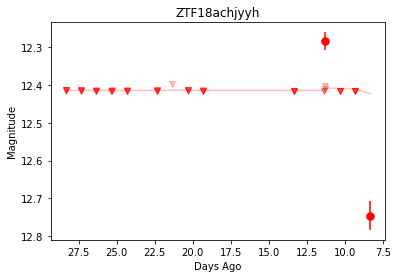

https://lasair.roe.ac.uk/object/ZTF18achjyyh/


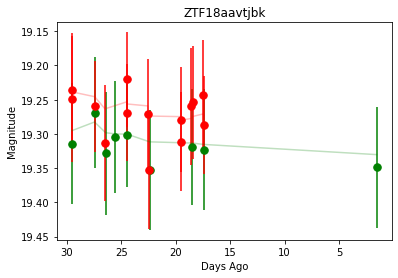

https://lasair.roe.ac.uk/object/ZTF18aavtjbk/


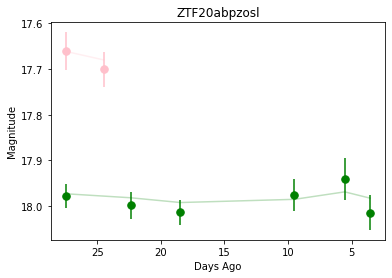

https://lasair.roe.ac.uk/object/ZTF20abpzosl/


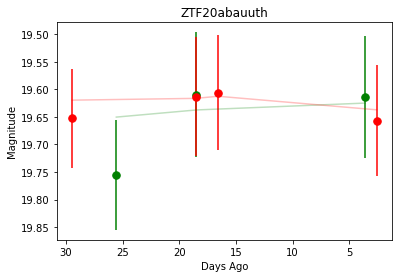

https://lasair.roe.ac.uk/object/ZTF20abauuth/


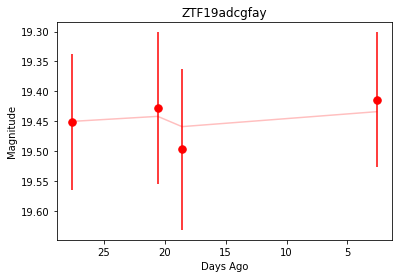

https://lasair.roe.ac.uk/object/ZTF19adcgfay/


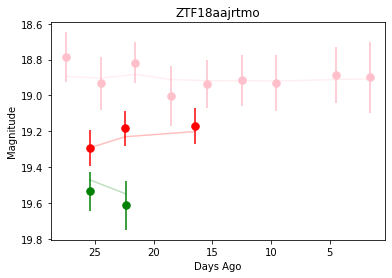

https://lasair.roe.ac.uk/object/ZTF18aajrtmo/


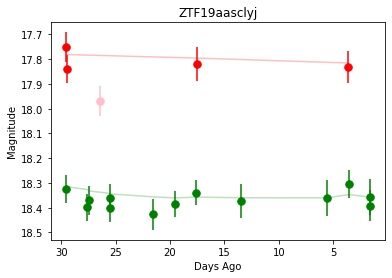

https://lasair.roe.ac.uk/object/ZTF19aasclyj/


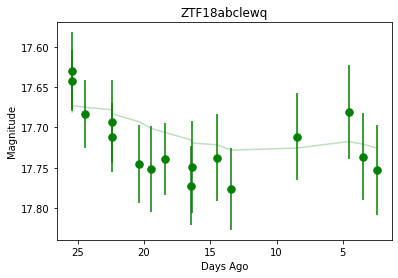

https://lasair.roe.ac.uk/object/ZTF18abclewq/


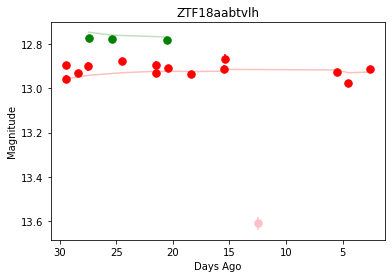

https://lasair.roe.ac.uk/object/ZTF18aabtvlh/


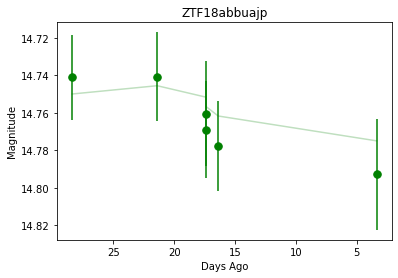

https://lasair.roe.ac.uk/object/ZTF18abbuajp/


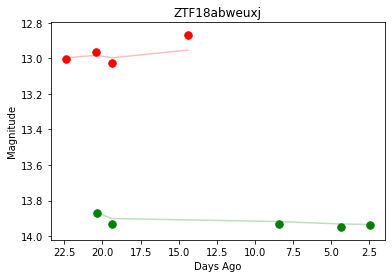

https://lasair.roe.ac.uk/object/ZTF18abweuxj/


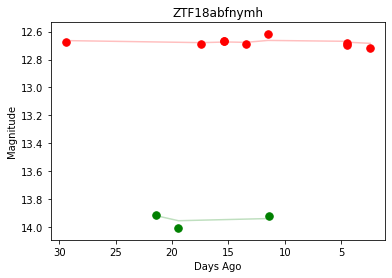

https://lasair.roe.ac.uk/object/ZTF18abfnymh/


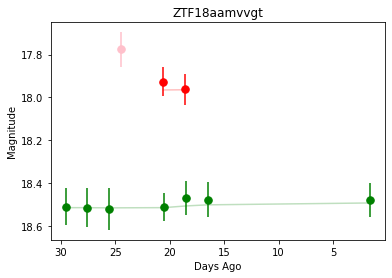

https://lasair.roe.ac.uk/object/ZTF18aamvvgt/


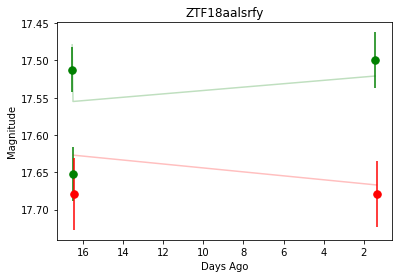

https://lasair.roe.ac.uk/object/ZTF18aalsrfy/


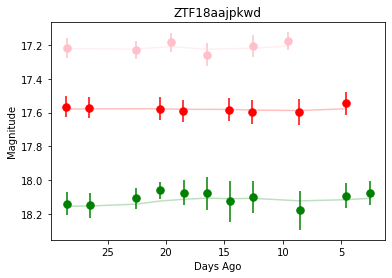

https://lasair.roe.ac.uk/object/ZTF18aajpkwd/


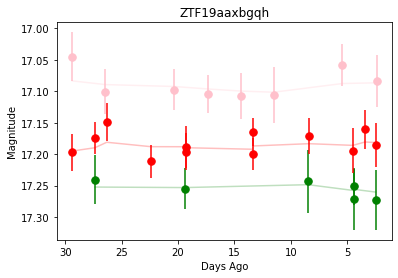

https://lasair.roe.ac.uk/object/ZTF19aaxbgqh/


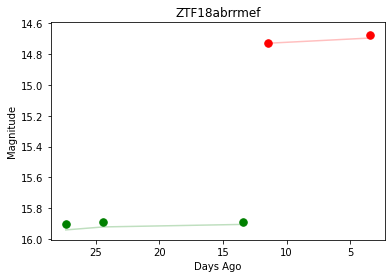

https://lasair.roe.ac.uk/object/ZTF18abrrmef/


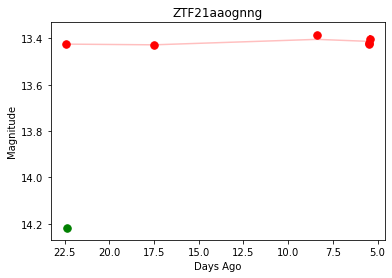

https://lasair.roe.ac.uk/object/ZTF21aaognng/


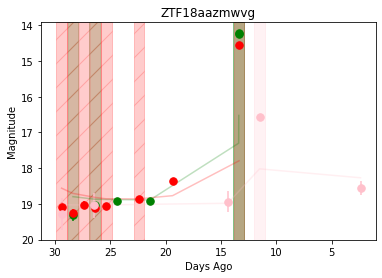

https://lasair.roe.ac.uk/object/ZTF18aazmwvg/


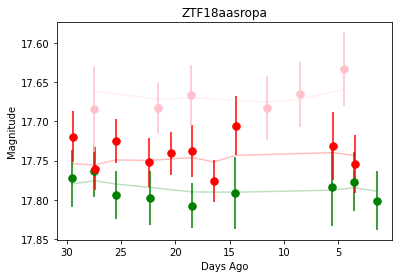

https://lasair.roe.ac.uk/object/ZTF18aasropa/


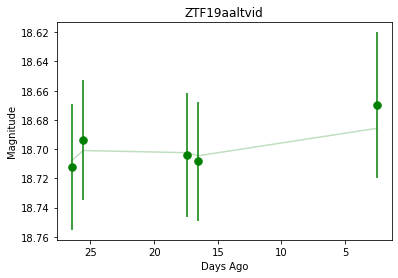

https://lasair.roe.ac.uk/object/ZTF19aaltvid/


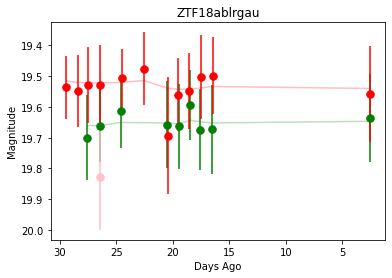

https://lasair.roe.ac.uk/object/ZTF18ablrgau/


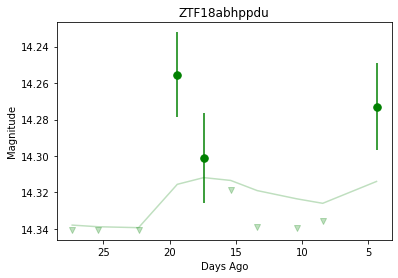

https://lasair.roe.ac.uk/object/ZTF18abhppdu/


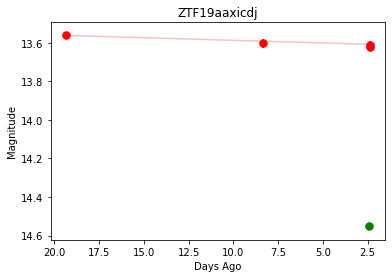

https://lasair.roe.ac.uk/object/ZTF19aaxicdj/


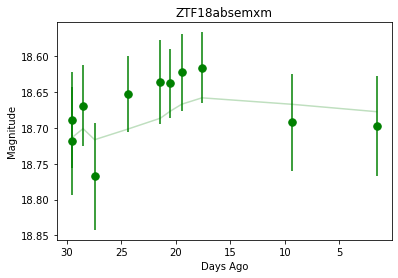

https://lasair.roe.ac.uk/object/ZTF18absemxm/


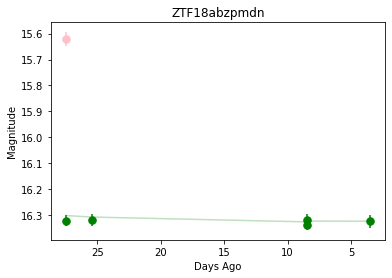

https://lasair.roe.ac.uk/object/ZTF18abzpmdn/


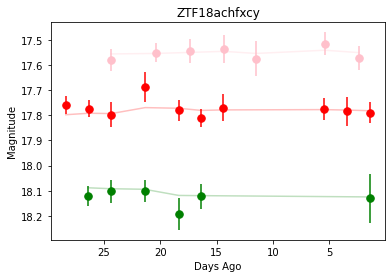

https://lasair.roe.ac.uk/object/ZTF18achfxcy/


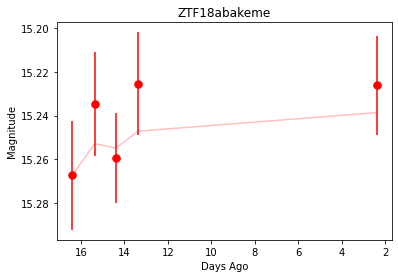

https://lasair.roe.ac.uk/object/ZTF18abakeme/


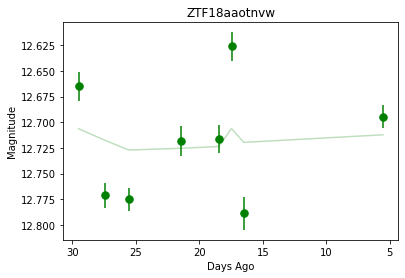

https://lasair.roe.ac.uk/object/ZTF18aaotnvw/


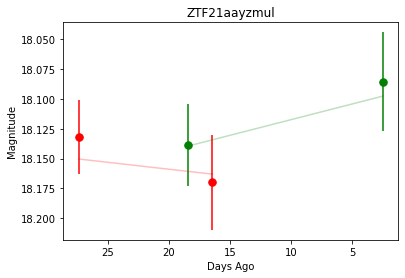

https://lasair.roe.ac.uk/object/ZTF21aayzmul/


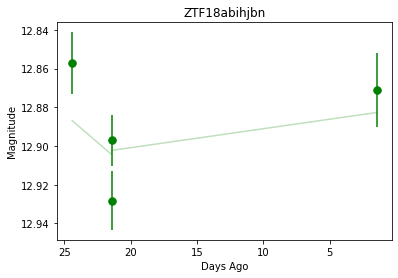

https://lasair.roe.ac.uk/object/ZTF18abihjbn/


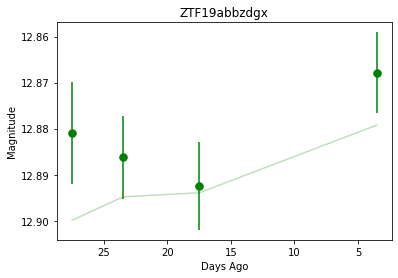

https://lasair.roe.ac.uk/object/ZTF19abbzdgx/


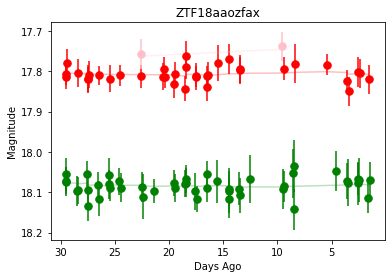

https://lasair.roe.ac.uk/object/ZTF18aaozfax/


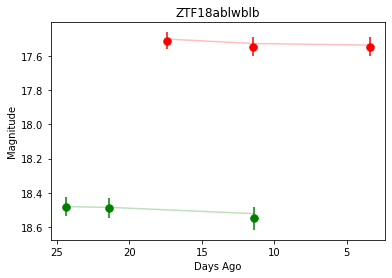

https://lasair.roe.ac.uk/object/ZTF18ablwblb/


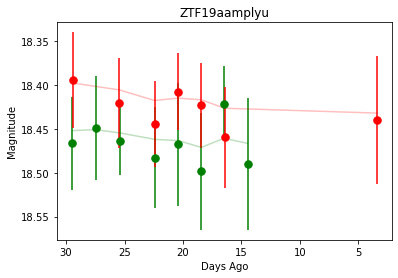

https://lasair.roe.ac.uk/object/ZTF19aamplyu/


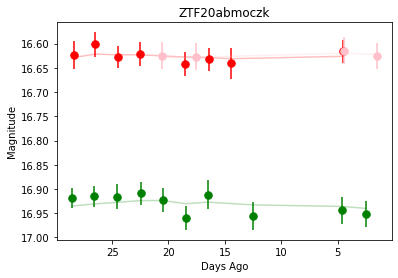

https://lasair.roe.ac.uk/object/ZTF20abmoczk/


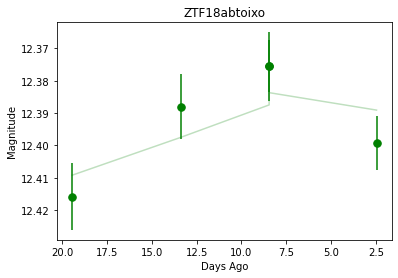

https://lasair.roe.ac.uk/object/ZTF18abtoixo/


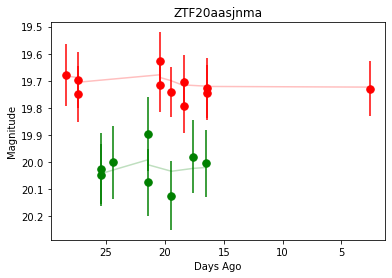

https://lasair.roe.ac.uk/object/ZTF20aasjnma/


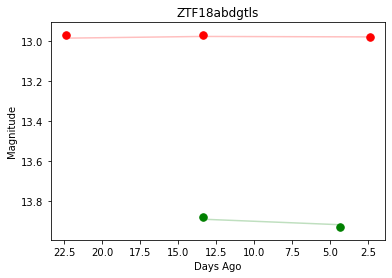

https://lasair.roe.ac.uk/object/ZTF18abdgtls/


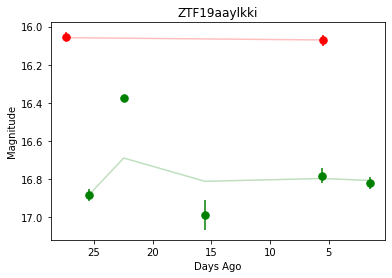

https://lasair.roe.ac.uk/object/ZTF19aaylkki/


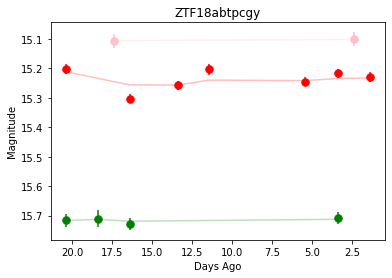

https://lasair.roe.ac.uk/object/ZTF18abtpcgy/


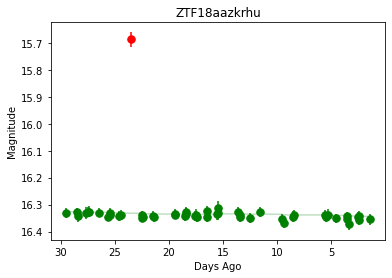

https://lasair.roe.ac.uk/object/ZTF18aazkrhu/


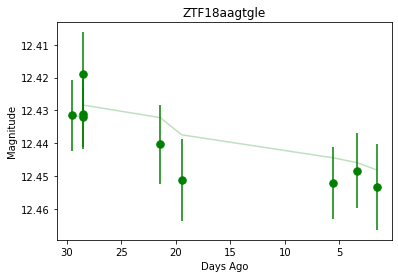

https://lasair.roe.ac.uk/object/ZTF18aagtgle/


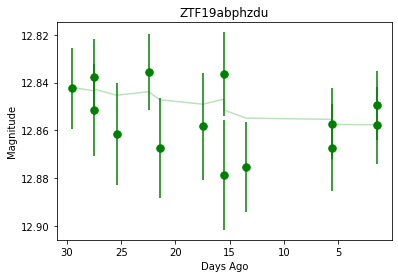

https://lasair.roe.ac.uk/object/ZTF19abphzdu/


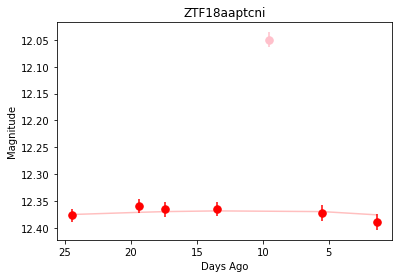

https://lasair.roe.ac.uk/object/ZTF18aaptcni/


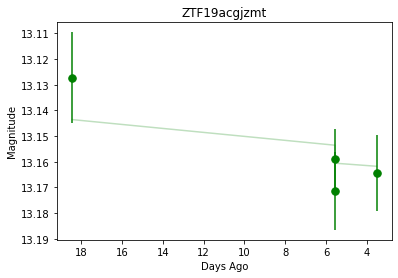

https://lasair.roe.ac.uk/object/ZTF19acgjzmt/


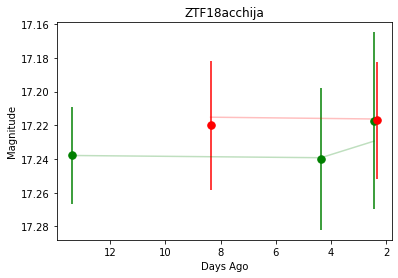

https://lasair.roe.ac.uk/object/ZTF18acchija/


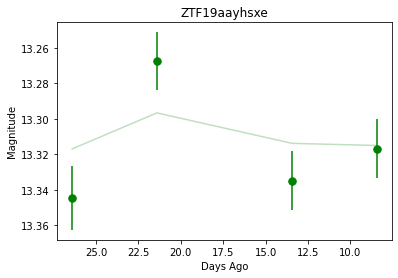

https://lasair.roe.ac.uk/object/ZTF19aayhsxe/


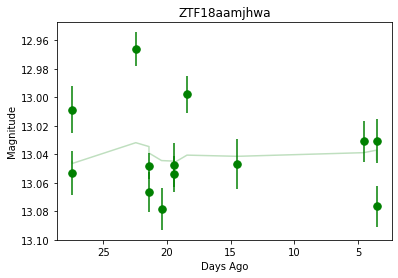

https://lasair.roe.ac.uk/object/ZTF18aamjhwa/


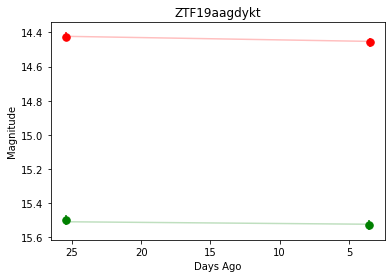

https://lasair.roe.ac.uk/object/ZTF19aagdykt/


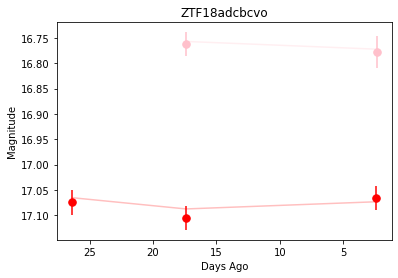

https://lasair.roe.ac.uk/object/ZTF18adcbcvo/


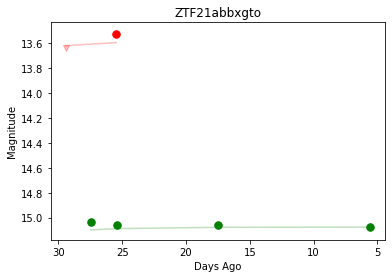

https://lasair.roe.ac.uk/object/ZTF21abbxgto/


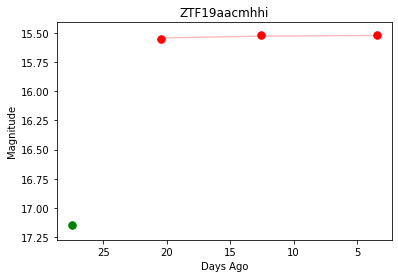

https://lasair.roe.ac.uk/object/ZTF19aacmhhi/


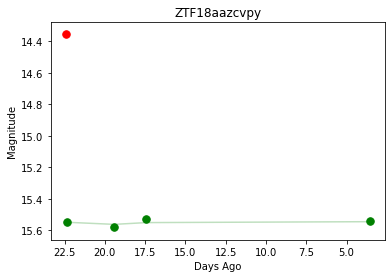

https://lasair.roe.ac.uk/object/ZTF18aazcvpy/


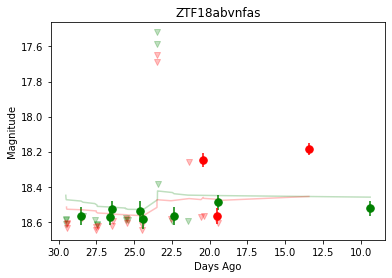

https://lasair.roe.ac.uk/object/ZTF18abvnfas/


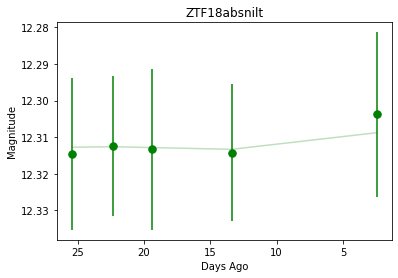

https://lasair.roe.ac.uk/object/ZTF18absnilt/


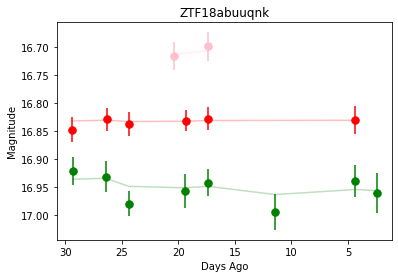

https://lasair.roe.ac.uk/object/ZTF18abuuqnk/


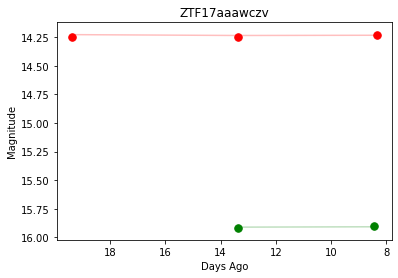

https://lasair.roe.ac.uk/object/ZTF17aaawczv/


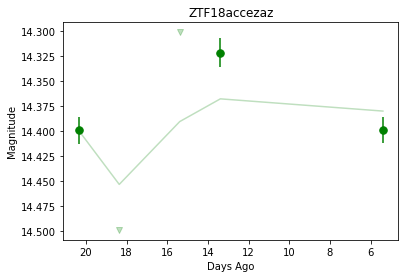

https://lasair.roe.ac.uk/object/ZTF18accezaz/


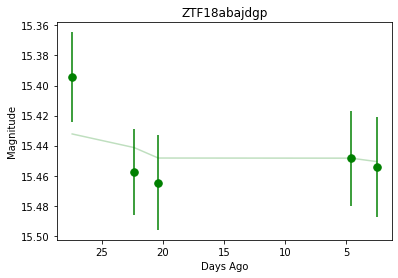

https://lasair.roe.ac.uk/object/ZTF18abajdgp/


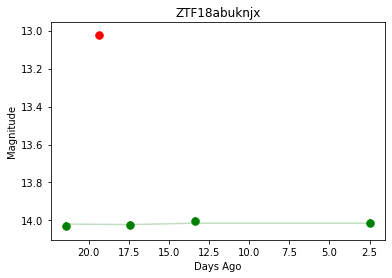

https://lasair.roe.ac.uk/object/ZTF18abuknjx/


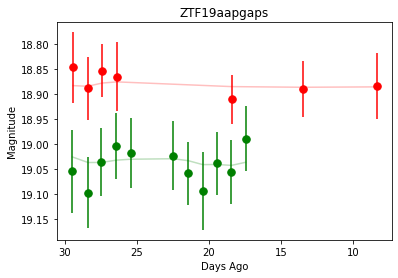

https://lasair.roe.ac.uk/object/ZTF19aapgaps/


In [40]:
for x in combined_order_by_max:
    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag_ulim'])
    if len(sub) > 3:
        plot_dc_lightcurve_lim(sub.reset_index(), x, ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=offset)
        print(f'https://lasair.roe.ac.uk/object/{x}/')
    # mark_seen(conn, x)
    # show_stamps(x)
    


In [39]:
test_sub = dflc_interest_new.loc['ZTF17aabwtnr'].dropna(subset=['dc_mag'])

## Set up panels

In [40]:
import panel as pn
pn.extension()

def create_alert_panel(conn, data, ztf_object_id, im_dir, plot_lc_kwargs):
    lc_plot = plot_dc_lightcurve(data, ztf_object_id, **plot_lc_kwargs)
    stamps = show_stamps(ztf_object_id, im_dir)
    
    mark_seen = pn.widgets.Toggle(name='Mark Seen', value=True)
    mark_interest = pn.widgets.Toggle(name='Mark Interest')
    
    notes = pn.widgets.TextInput(value='Notes', width=750)
    
    def b(event):
        if notes.value == 'Notes':
            notes = '""'
        else:
            notes = f'"{notes}"'
        data_to_update = {"seen_flag": mark_seen.value, "interest_flag": mark_interest.value,
                  "notes": notes}
        # update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')
        print(data_to_update)
        output.value = 'testing...'
    submit = pn.widgets.Button(name='Submit', color='danger')
    submit.on_click(b)
    
    output = pn.widgets.TextInput(value='Output')
    test_panel = pn.Column(pn.Row(f'#{ztf_object_id}', align='center'), 
                           pn.Row(lc_plot, align='center'),
                           pn.Row(mark_seen, mark_interest, align='center'),
                           pn.Row(stamps),
                           pn.Row(notes, align='center'),
                           pn.Row(submit, output, align='center'))
    return test_panel

INFO: Auto-setting vmin to  2.815e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.914e+03 [aplpy.core]
INFO: Auto-setting vmin to  2.899e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.392e+02 [aplpy.core]


INFO: Auto-setting vmin to -1.408e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.439e+03 [aplpy.core]


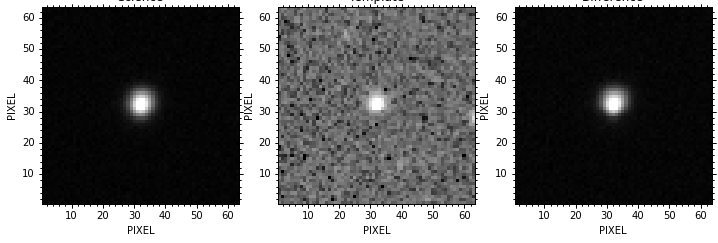

In [41]:
plot_lc_kwargs = {'ema': 'ema8', 'ema_diff': 'mag_ewm_diff8_rolling4', 'offset':offset, 'show':False}
ztf_object_id = 'ZTF17aabwtnr'
test = create_alert_panel(conn, dflc_interest_new.loc[ztf_object_id].dropna(subset=['dc_mag']).reset_index(), ztf_object_id, cutout_dir, plot_lc_kwargs)


Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row(align='center')
        [0] Matplotlib(Figure)
    [2] Row(align='center')
        [0] Toggle(name='Mark Seen', value=True)
        [1] Toggle(name='Mark Interest')
    [3] Row
        [0] Matplotlib(Figure)
    [4] Row(align='center')
        [0] TextInput(value='Notes', width=750)
    [5] Row(align='center')
        [0] Button(name='Submit')
        [1] TextInput(value='Output')
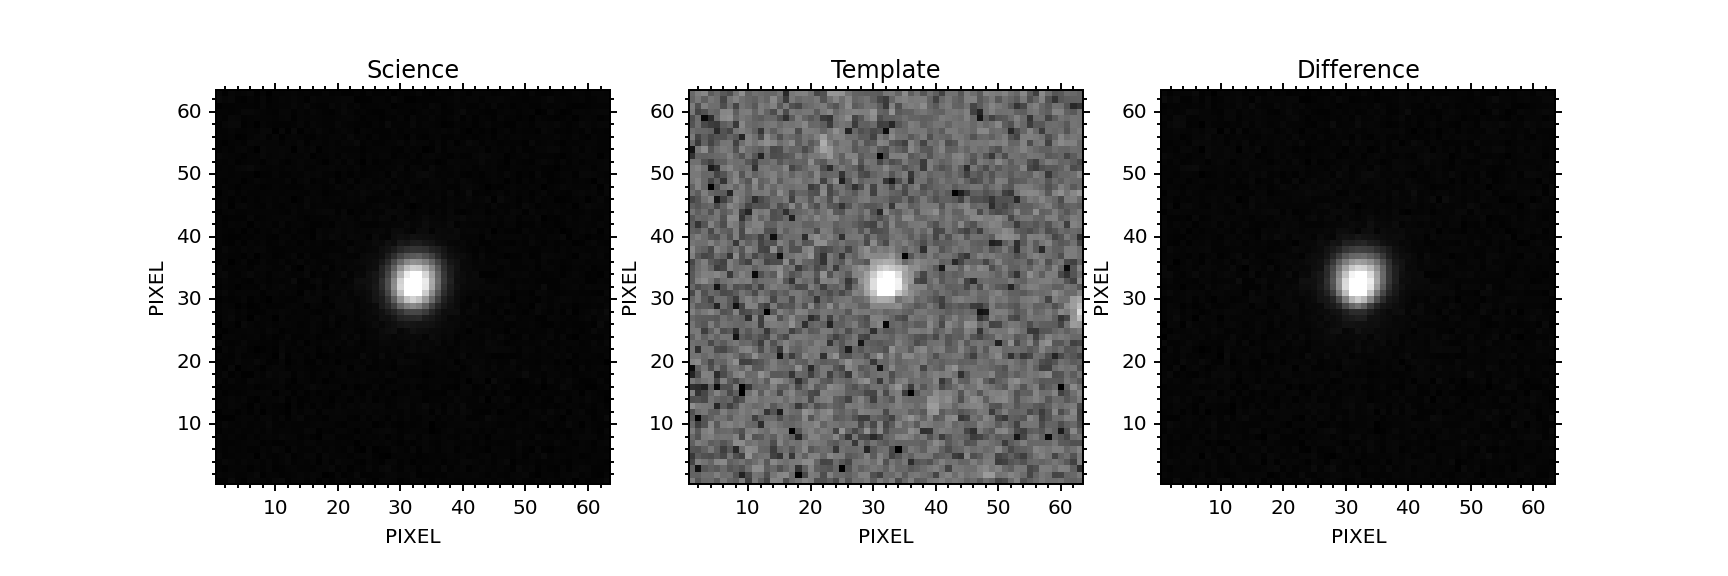
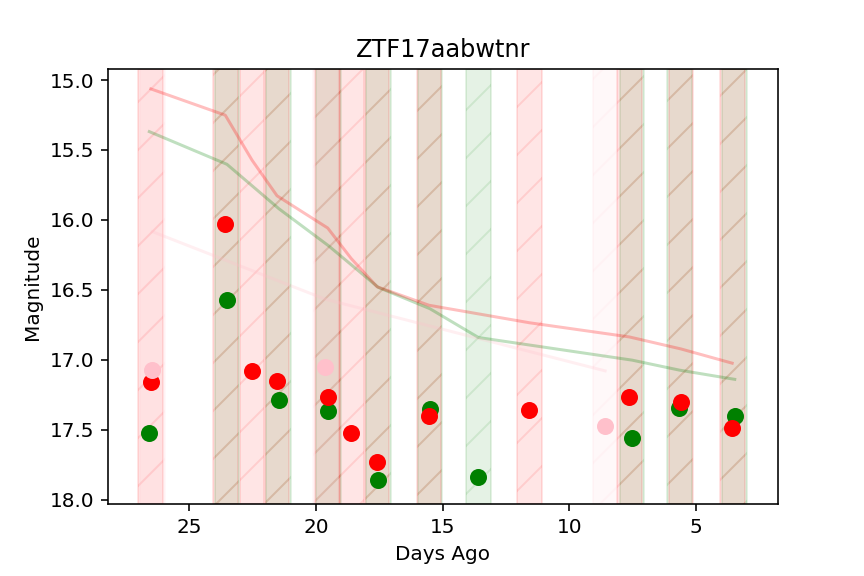

In [42]:
test

### check if updating worked 
not working yet

In [43]:
conn = sqlite3.connect('../local/db/sqlite_pid2.db')
df = pd.read_sql_query("SELECT * FROM ZTF_objects", conn)
df.columns = ['ztf_object_id', 'SIMBAD_otype', 'ra', 'dec', 'ROSAT_IAU_NAME',
       'SIMBAD_include', 'last_obs', 'seen_flag', 'interest_flag', 'notes']
df.query('ztf_object_id == "ZTF18aabefzb"')
df.query('ztf_object_id == "ZTF17aaairkd"')

ztf_object_id SIMBAD_otype          ra       dec         ROSAT_IAU_NAME  \
4676  ZTF17aaairkd          AM*  106.041859  62.05777  2RXS J070409.2+620329   

      SIMBAD_include      last_obs  seen_flag  interest_flag notes  
4676             1.0  2.459359e+06        NaN            NaN  None

In [52]:
# example updating
# data_to_update = {"seen_flag": 1, "interest_flag": 0,
#                   "notes": '"testing"'}
data_to_update = {"seen_flag": 0, "interest_flag": 1,
                  "notes": '""'}
update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')

## Explore panels

In [39]:
import hvplot.pandas
from bokeh.sampledata.autompg import autompg

def autompg_plot(x='mpg', y='hp', color='#058805'):
    return autompg.hvplot.scatter(x, y, c=color, padding=0.1)

columns = list(autompg.columns[:-2])

In [43]:
color = pn.widgets.ColorPicker(name='Color', value='#4f4fdf')
layout = pn.interact(autompg_plot, x=columns, y=columns, color=color)

pn.Row(pn.Column('## MPG Explorer', layout[0]), layout[1])

Row
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Select(name='x', options=['mpg', 'cyl', ...], value='mpg')
            [1] Select(name='y', options=['mpg', 'cyl', ...], value='hp')
            [2] ColorPicker(name='Color', value='#4f4fdf')
    [1] Row
        [0] HoloViews(Scatter, name='interactive01461')

In [59]:
columns

['mpg', 'cyl', 'displ', 'hp', 'weight', 'accel', 'yr']

In [44]:
x = pn.widgets.Select(value='mpg', options=columns, name='x')
y = pn.widgets.Select(value='hp', options=columns, name='y')
color = pn.widgets.ColorPicker(name='Color', value='#880588')

layout = pn.Row(
    pn.Column('## MPG Explorer', x, y, color),
    autompg_plot(x.value, y.value, color.value))

def update(event):
    layout[1].object = autompg_plot(x.value, y.value, color.value)

x.param.watch(update, 'value')
y.param.watch(update, 'value')
color.param.watch(update, 'value')

layout

Row
    [0] Column
        [0] Markdown(str)
        [1] Select(name='x', options=['mpg', 'cyl', ...], value='mpg')
        [2] Select(name='y', options=['mpg', 'cyl', ...], value='hp')
        [3] ColorPicker(name='Color', value='#880588')
    [1] HoloViews(Scatter)

In [45]:
autompg_plot(x.value, y.value, color.value)

:Scatter   [mpg]   (hp)

In [60]:
ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')


In [76]:
import param


In [91]:
class ZTF_panel(param.Parameterized):
    update = param.Action(lambda self: self._action_update())
    
    def __init__(self, **params):
        super(ZTF_panel, self).__init__(**params)
        self.ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')
        self.fig = plot_dc_lightcurve(dflc_interest_new.loc[self.ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), self.ztf_object_id.value, **plot_lc_kwargs)
        self.mpl = pn.pane.Matplotlib(self.fig)
        
    @param.depends('update', watch=True)    
    def _action_update(self):
        
        self.fig = plot_dc_lightcurve(dflc_interest_new.loc[self.ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), self.ztf_object_id.value, **plot_lc_kwargs)
        self.mpl.param.trigger('object')
    
    def panel(self):
        return pn.Column(pn.Row(f'#{self.ztf_object_id.value}', align='center'), 
                   pn.Row(self.ztf_object_id),
                       pn.Row(self.mpl, align='center'))

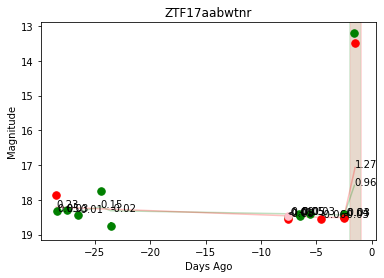

In [92]:
test = ZTF_panel()

In [83]:
print(test.panel())

Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row
        [0] Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF18aauqlbf')
    [2] Row(align='center')
        [0] Matplotlib(Figure)


Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row
        [0] Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF17aabwtnr')
    [2] Row(align='center')
        [0] Matplotlib(Figure)
    [3] Row(align='center')
        [0] Toggle(name='Mark Seen', value=True)
        [1] Toggle(name='Mark Interest')
    [4] Row(align='center')
        [0] TextInput(value='Notes', width=750)
    [5] Row(align='center')
        [0] Button(name='Submit')
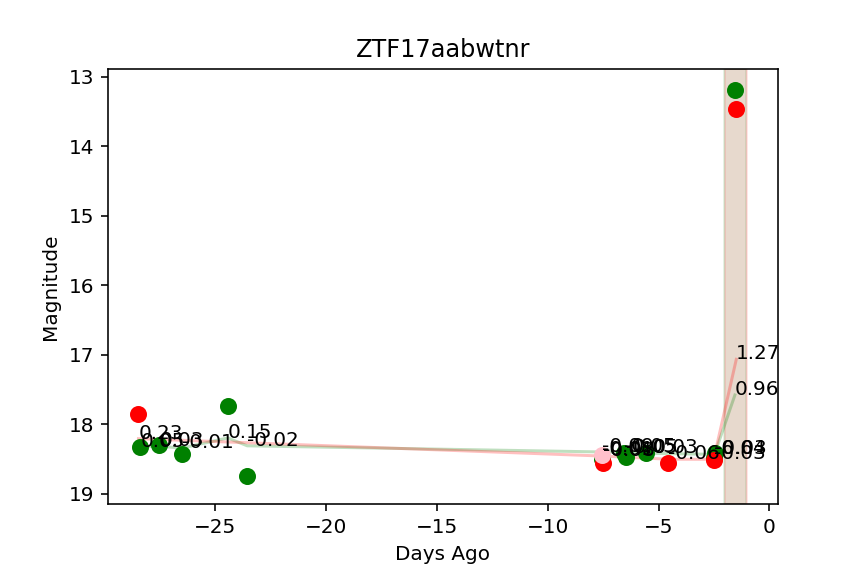

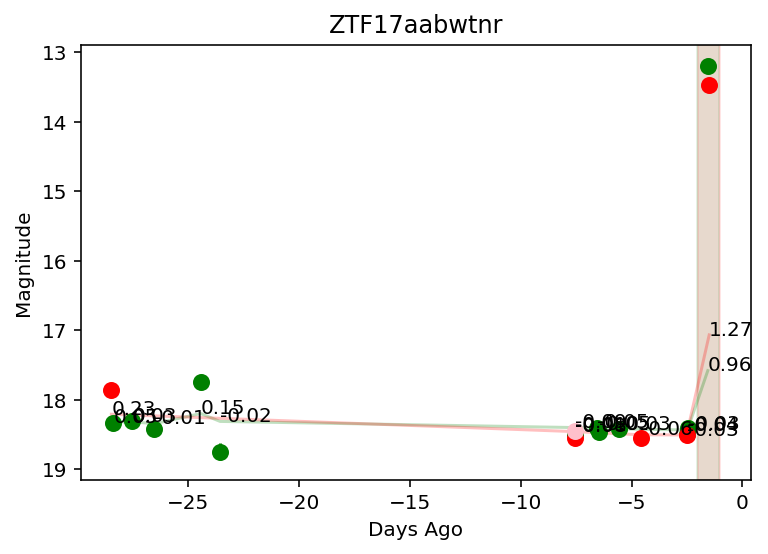

In [72]:
ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')

# stamps = show_stamps(ztf_object_id.value, im_dir)
mpl_pane = pn.pane.Matplotlib(plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), ztf_object_id.value, **plot_lc_kwargs), dpi=144)

mark_seen = pn.widgets.Toggle(name='Mark Seen', value=True)
mark_interest = pn.widgets.Toggle(name='Mark Interest')

notes = pn.widgets.TextInput(value='Notes', width=750)

def b(event):
    if notes.value == 'Notes':
        notes = '""'
    else:
        notes = f'"{notes}"'
    data_to_update = {"seen_flag": mark_seen.value, "interest_flag": mark_interest.value,
              "notes": notes}
    # update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')
    print(data_to_update)
    output.value = 'testing...'
    
def update(event):
    mpl_pane = pn.pane.Matplotlib(plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), ztf_object_id.value, **plot_lc_kwargs), dpi=144)
    layout[2].object = mpl_pane
    
submit = pn.widgets.Button(name='Submit')
# submit.on_click(b)

layout = pn.Column(pn.Row(f'#{ztf_object_id.value}', align='center'), 
                   pn.Row(ztf_object_id),
                       pn.Row(mpl_pane, align='center'),
                       pn.Row(mark_seen, mark_interest, align='center'),
                       # pn.Row(stamps),
                       pn.Row(notes, align='center'),
                       pn.Row(submit, align='center'))

ztf_object_id.param.watch(update, 'value')

layout

Matplotlib(Figure)
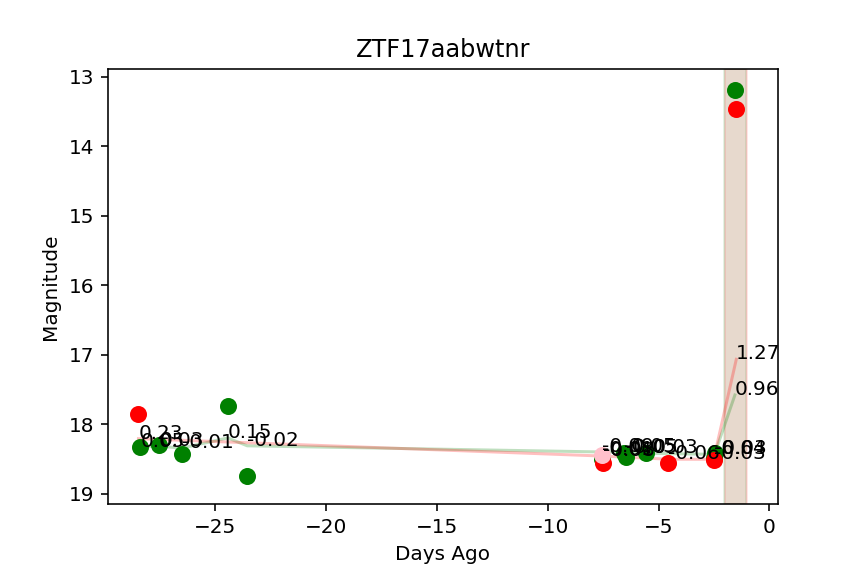

In [73]:
mpl_pane

In [96]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

import matplotlib.pyplot as plt

breast_cancer = load_breast_cancer()

print("Feature Names", breast_cancer.feature_names)
print("Target : ", breast_cancer.target_names)
print("Dataset Size : ", breast_cancer.data.shape)

breast_cancer_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df["Target"] = breast_cancer.target
breast_cancer_df["Target"] = ['Malignant' if typ==0 else 'Benign' for typ in breast_cancer_df["Target"]]
breast_cancer_df.head()

Feature Names ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target :  ['malignant' 'benign']
Dataset Size :  (569, 30)


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  radius error  texture error  perimeter error  \
0                 0.07871        1.0950         0.9053            8.589   
1                 0.05667        0.5435         0.7339            3.398   
2                 0.05999        0.7456         0.7869            4.585   
3                 0.09744        0.4956         1.1560            3.445   
4                 0.05883        0.7572         0.7813            5.438   

   area error  smoothness error  compactness error  concavity error  \
0      153.40          0.006399            0.04904          0.05373   
1       74.08          0.005225            0.01308          0.01860   
2       94.03          0.006150            0.04006          0.03832   
3       27.23          0.009110            0.07458          0.05661   
4       94.44          0.011490            0.02461          0.05688   

   concave points error  symmetry error  fractal dimension error  \
0               0.01587         0.03003                 0.006193   
1               0.01340         0.01389                 0.003532   
2               0.02058         0.02250                 0.004571   
3               0.01867         0.05963                 0.009208   
4               0.01885         0.01756                 0.005115   

   worst radius  worst texture  worst perimeter  worst area  worst smoothness  \
0         25.38          17.33           184.60      2019.0            0.1622   
1         24.99          23.41           158.80      1956.0            0.1238   
2         23.57          25.53           152.50      1709.0            0.1444   
3         14.91          26.50            98.87       567.7            0.2098   
4         22.54          16.67           152.20      1575.0            0.1374   

   worst compactness  worst concavity  worst concave points  worst symmetry  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   worst fractal dimension     Target  
0                  0.11890  Malignant  
1                  0.08902  Malignant  
2                  0.08758  Malignant  
3                  0.17300  Malignant  
4                  0.07678  Malignant

In [97]:
import matplotlib.gridspec as gridspec

def create_figure(plot1_f1,plot1_f2, plot2_f,plot3_f):
    with plt.style.context(("seaborn","ggplot")):
        fig = plt.figure(constrained_layout=True, figsize=(10,8))
        specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig) ## Declaring 2x2 figure.

        ax1 = fig.add_subplot(specs[0, :]) ## First Row
        ax2 = fig.add_subplot(specs[1, 0]) ## Second Row First Column
        ax3 = fig.add_subplot(specs[1, 1]) ## Second Row Second Colums

        ## First Graph -  Scatter Plot
        color = {"Malignant" : "tab:red", "Benign":"tab:green"}
        for tumor_typ in breast_cancer_df["Target"].unique():
            ax1.scatter(breast_cancer_df[breast_cancer_df["Target"]==tumor_typ][plot1_f1],
                        breast_cancer_df[breast_cancer_df["Target"]==tumor_typ][plot1_f2],
                        c=color[tumor_typ],
                        s=200,
                        alpha=0.6,
                        label=tumor_typ)
        ax1.set_xlabel(plot1_f1)
        ax1.set_ylabel(plot1_f2)
        ax1.set_title("%s vs %s Scatter Plot"%(plot1_f1, plot1_f2))
        ax1.legend(title="Tumor Type",loc="best")

        ## Second Graph - Bar Chart
        avg_radius_per_tumor_typ = breast_cancer_df.groupby(by="Target").mean()[[plot2_f]]
        ax2.bar(avg_radius_per_tumor_typ.index,
                avg_radius_per_tumor_typ[plot2_f],
                color="tab:blue",
                width=0.6)
        ax2.set_ylabel(plot2_f)
        ax2.set_title("Average %s per tumor type"%(plot2_f))

        ## Third Graph - Histogram
        ax3.hist(breast_cancer_df[plot3_f], color="tab:orange", )
        ax3.set_ylabel(plot3_f)
        ax3.set_title("%s distribution"%(plot3_f))

        plt.close(fig)
        return fig

In [101]:
f1 = pn.widgets.Select(options=list(breast_cancer.feature_names), name="Scatter Plot Feature 1")
f2 = pn.widgets.Select(options=list(breast_cancer.feature_names), name="Scatter Plot Feature 2")
f3 = pn.widgets.Select(options=list(breast_cancer.feature_names), name="Bar Chart Feature")
f4 = pn.widgets.Select(options=list(breast_cancer.feature_names), name="Histogram Feature")

In [105]:
f1

Select(name='Scatter Plot Feature 1', options=['mean radius', ...], value='mean smoothness')

In [108]:
@pn.depends(f1.param.value,f2.param.value,f3.param.value,f4.param.value)
def create_dash(f1,f2,f3,f4):
    return create_figure(f1,f2,f3,f4)

Column
    [0] StaticText(align='center', value='<h3>Breast Cancer D...)
    [1] Row(align='center')
        [0] Select(name='Scatter Plot Feature 1', options=['mean radius', ...], value='mean smoothness')
        [1] Select(name='Scatter Plot Feature 2', options=['mean radius', ...], value='mean radius')
    [2] Row(align='center')
        [0] Select(name='Bar Chart Feature', options=['mean radius', ...], value='mean radius')
        [1] Select(name='Histogram Feature', options=['mean radius', ...], value='mean radius')
    [3] Row
        [0] ParamFunction(function)
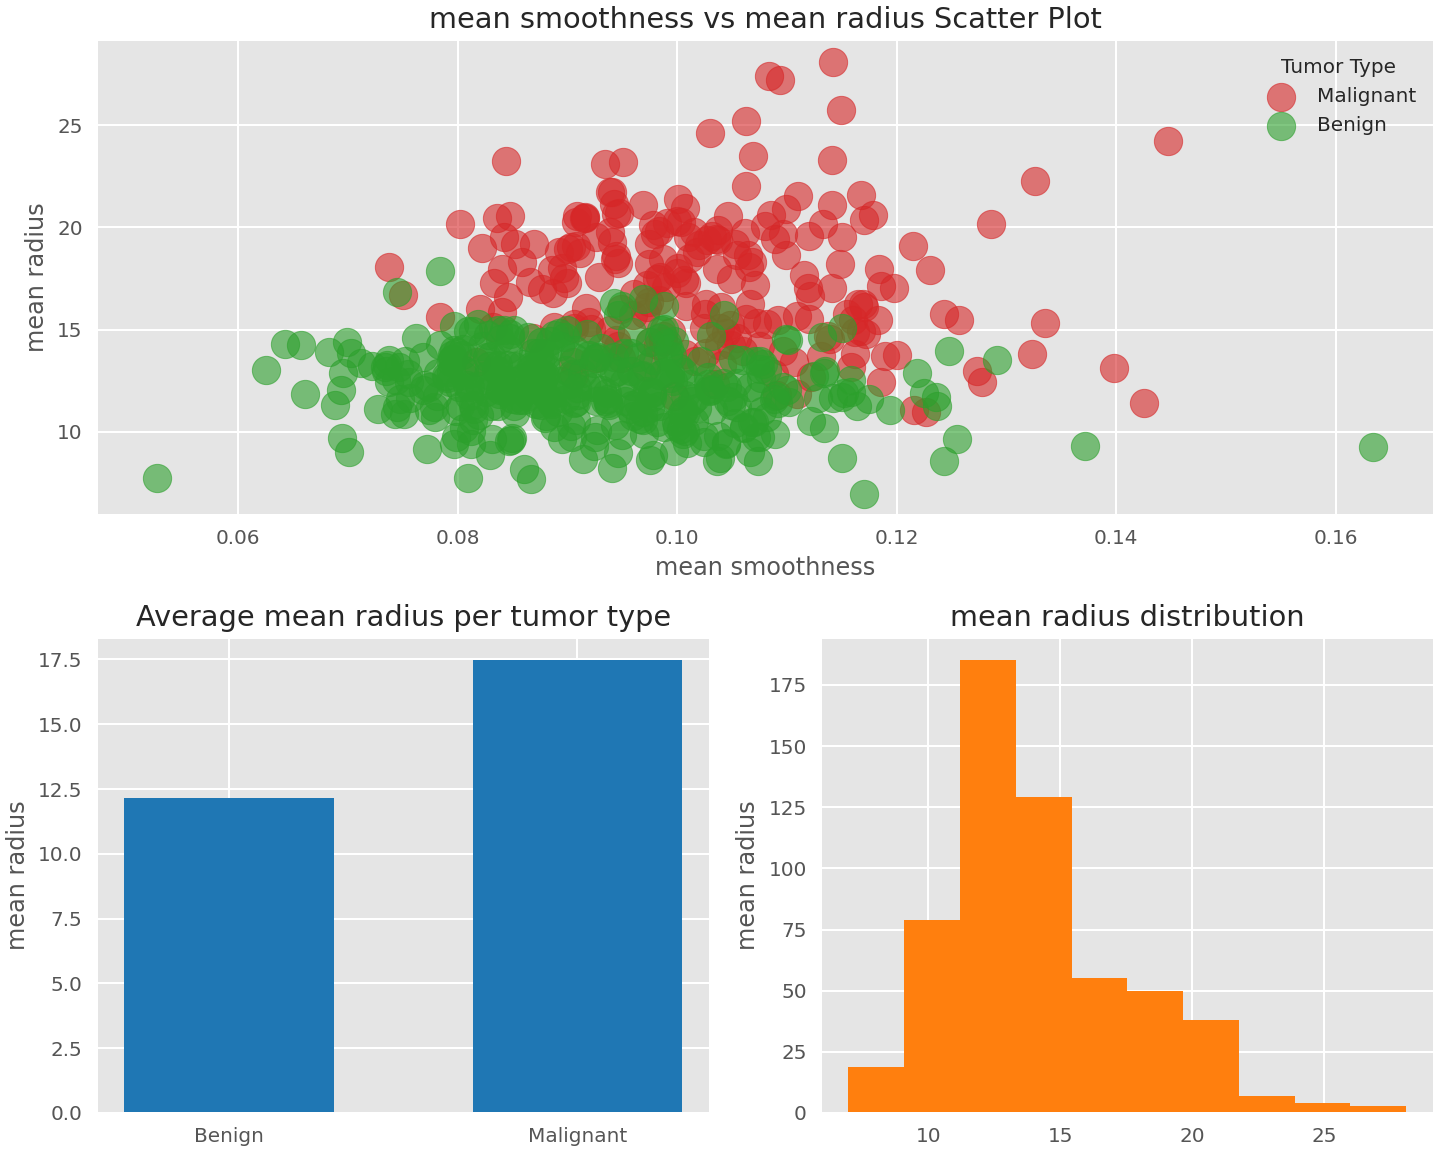

In [109]:
heading = "<h3>Breast Cancer Data Analysis Dashboard</h3>\nPlease feel free to try various combinations of parameters to analyze results from different angles"
text = pn.widgets.StaticText(value=heading, align="center")

dash3 = pn.Column(
                    text,
                    pn.Row(f1,f2, align="center"),
                    pn.Row(f3,f4, align="center"),
                    pn.Row(create_dash)
                )
dash3

test


test

Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row
        [0] Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF17aabwtnr')
    [2] Row
        [0] Button(name='Next')
    [3] Row(align='center')
        [0] ParamFunction(function)
    [4] Row(align='center')
        [0] ParamFunction(function)
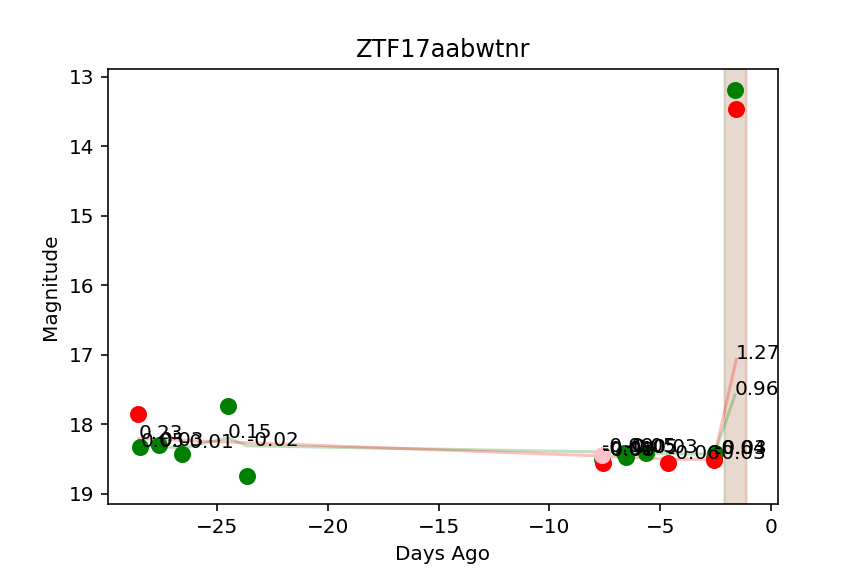
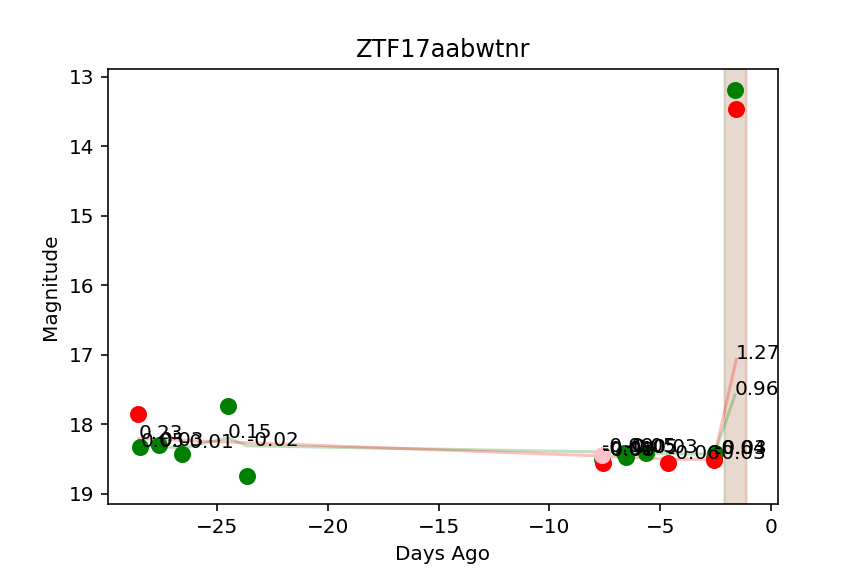

In [136]:
ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')

# stamps = show_stamps(ztf_object_id.value, im_dir)
mpl_pane = pn.pane.Matplotlib(plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), ztf_object_id.value, **plot_lc_kwargs), dpi=144)

ii=0
@pn.depends(ztf_object_id.param.value)
def create_dash(ztf_object_id):
    print('test')
    return plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id].dropna(subset=['dc_mag']).reset_index(), ztf_object_id, **plot_lc_kwargs)

submit = pn.widgets.Button(name='Next')

@pn.depends(submit.param.value)
def create_dash2(mpl_pane):
    # print('test')
    return plot_dc_lightcurve(dflc_interest_new.loc[order_by_max[submit.clicks]].dropna(subset=['dc_mag']).reset_index(), order_by_max[submit.clicks], **plot_lc_kwargs)


layout = pn.Column(pn.Row(f'#{ztf_object_id.value}', align='center'), 
                   pn.Row(ztf_object_id),
                   pn.Row(submit),
                   pn.Row(create_dash, align='center'),
                   pn.Row(create_dash2, align='center'))


# ztf_object_id.param.watch(update, 'value')
layout

In [133]:
ztf_object_id

Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF18abbuvrd')

In [135]:
ztf_object_id.value = 'ZTF18abbuvrd'

Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row
        [0] Select(name='ztf_object_id', options=['ZTF17aabwtnr', ...], value='ZTF17aabwtnr')
    [2] Row
        [0] Button(name='Previous')
        [1] Button(name='Next')
    [3] Row(align='center')
        [0] ParamFunction(function)
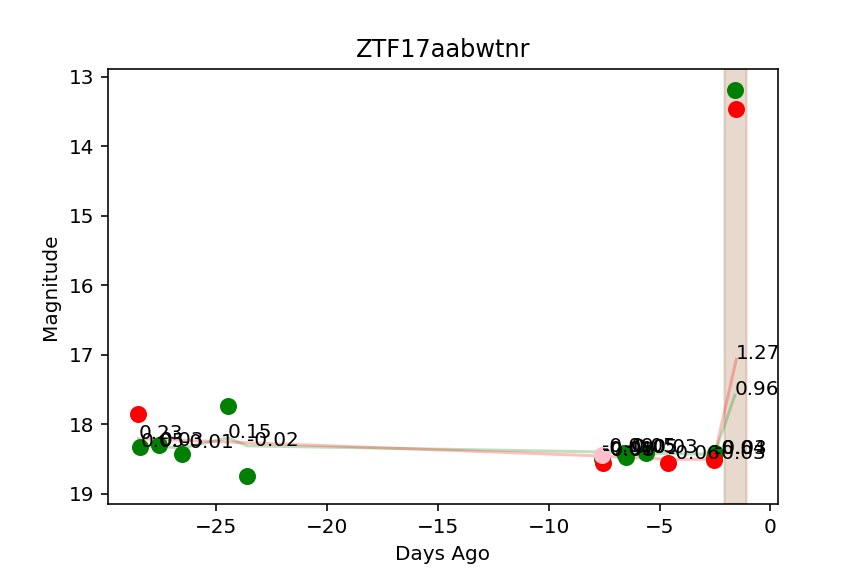

In [130]:
ztf_object_id = pn.widgets.Select(value='ZTF17aabwtnr', options=list(order_by_max), name='ztf_object_id')

# stamps = show_stamps(ztf_object_id.value, im_dir)
mpl_pane = pn.pane.Matplotlib(plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id.value].dropna(subset=['dc_mag']).reset_index(), ztf_object_id.value, **plot_lc_kwargs), dpi=144)

ii=0
@pn.depends(ztf_object_id.param.value, submit.param.value)
def create_dash(obj_id, goto_next, goto_prev):
    return plot_dc_lightcurve(dflc_interest_new.loc[ztf_object_id].dropna(subset=['dc_mag']).reset_index(), ztf_object_id, **plot_lc_kwargs)

submit = pn.widgets.Button(name='Next')
prev = pn.widgets.Button(name='Previous')

layout = pn.Column(pn.Row(f'#{ztf_object_id.value}', align='center'), 
                   pn.Row(ztf_object_id),
                   pn.Row(prev, submit),
                   pn.Row(create_dash, align='center'))


# ztf_object_id.param.watch(update, 'value')
layout

### Add columns to existing dbs

In [81]:
def add_column(conn, table, col_name, col_type):
    cur = conn.cursor()
    cur.execute(f"ALTER TABLE {table} ADD COLUMN {col_name} {col_type};")
    return pd.read_sql_query(f"SELECT * FROM {table}", conn).dtypes


In [133]:
conn_debug = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')


In [134]:
add_column(conn_debug, 'ZTF_objects', 'last_obs', 'float')
add_column(conn_debug, 'ZTF_objects', 'seen_flag', 'int')
add_column(conn_debug, 'ZTF_objects', 'interest_flag', 'int')
add_column(conn_debug, 'ZTF_objects', 'notes', 'text')

ZTF_object_id      object
SIMBAD_otype       object
ra                float64
dec               float64
ROSAT_IAU_NAME     object
SIMBAD_include    float64
last_obs           object
seen_flag          object
interest_flag      object
notes              object
dtype: object

In [90]:
pd.read_sql_query("SELECT * FROM lightcurves", conn).dtypes

ZTF_object_id     object
jd                object
fid               object
magpsf           float64
sigmapsf         float64
diffmaglim       float64
isdiffpos         object
magnr            float64
sigmagnr         float64
dtype: object

In [182]:
conn_debug = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')

pd.read_sql_query("SELECT * FROM ZTF_objects", conn_debug).dropna(subset=['ra'])

ZTF_object_id SIMBAD_otype         ra        dec         ROSAT_IAU_NAME  \
30   ZTF18aabezub         None  40.207699  49.865258  2RXS J024048.8+495203   
31   ZTF18acmysaq          BLL  53.486514  65.615648  2RXS J033357.0+653705   
32   ZTF20aaffcza         None  57.535898  76.662918  2RXS J035011.9+764002   
33   ZTF18absqkfg            G  43.684938  47.442902  2RXS J025444.0+472639   
34   ZTF19abjolmq         None  64.610641  73.275639  2RXS J041824.0+731635   
..            ...          ...        ...        ...                    ...   
336  ZTF18acbzkta         None  63.756536  32.335179  2RXS J041501.6+322002   
337  ZTF18abydmyu          DN*  86.951510  28.586512  2RXS J054748.5+283511   
338  ZTF18achucnm         None  63.549904  36.601002  2RXS J041413.5+363554   
339  ZTF18acdyfgs          QSO  38.043686  32.663463  2RXS J023209.8+323932   
340  ZTF18aaaknud         None  59.079078  42.994222  2RXS J035619.5+425940   

     SIMBAD_include      last_obs  seen_flag  interest_flag notes  
30              0.0  2.459270e+06        0.0            0.0  None  
31              0.0  2.459270e+06        0.0            0.0  None  
32              0.0  2.459270e+06        0.0            0.0  None  
33              0.0  2.459270e+06        0.0            0.0  None  
34              0.0  2.459270e+06        0.0            0.0  None  
..              ...           ...        ...            ...   ...  
336             0.0  2.459270e+06        0.0            0.0  None  
337             1.0  2.459270e+06        0.0            1.0  None  
338             0.0  2.459270e+06        0.0            0.0  None  
339             0.0  2.459270e+06        0.0            0.0  None  
340             0.0  2.459270e+06        0.0            0.0  None  

[211 rows x 10 columns]

In [84]:
cnx = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitesimple.db')
add_column(cnx, 'lightcurves', 'field', 'int')
add_column(cnx, 'lightcurves', 'rcid', 'int')
pd.read_sql_query("SELECT * FROM lightcurves", cnx)

ZTF_object_id               jd fid     magpsf  sigmapsf  diffmaglim  \
0       ZTF19abceihx  2459218.6020023   1  19.221775  0.175954   19.369980   
1       ZTF19abceihx  2459189.6685648   2  19.011000  0.137446   19.469000   
2       ZTF19abceihx  2459189.6930556   2  18.864500  0.107180   19.620899   
3       ZTF19abceihx  2459192.6256366   2  18.951799  0.252563   18.841499   
4       ZTF19abceihx   2459192.627037   2  18.754900  0.192248   18.947001   
...              ...              ...  ..        ...       ...         ...   
374540  ZTF18abtoupn  2459274.0565162   2  15.225590  0.020630   18.288145   
374541  ZTF18aborthl  2459274.0565162   2  17.907963  0.153364   18.162607   
374542  ZTF18abtovjo  2459274.0545486   2  17.512791  0.111764   18.462793   
374543  ZTF18absuniq  2459274.0574537   2  17.610895  0.168301   18.063719   
374544  ZTF18abtovjo  2459274.0569792   2  17.694727  0.115781   18.274311   

       isdiffpos      magnr  sigmagnr field  rcid  
0              f  17.524000     0.014  None  None  
1              f  17.299000     0.018  None  None  
2              f  17.243000     0.020  None  None  
3              f  17.299000     0.018  None  None  
4              f  17.243000     0.020  None  None  
...          ...        ...       ...   ...   ...  
374540         f  14.506000     0.020  None  None  
374541         f  16.231001     0.026  None  None  
374542         t  16.457001     0.015  None  None  
374543         t  15.917999     0.016  None  None  
374544         t  16.457001     0.015  None  None  

[374545 rows x 11 columns]

In [89]:
cnx = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')
pd.read_sql_query("SELECT * FROM lightcurves", cnx)

ZTF_object_id               jd fid     magpsf  sigmapsf  diffmaglim  \
0      ZTF18aabezub  2459269.6372801   2  18.705532  0.082297   20.220669   
1      ZTF18aabezub  2459248.6617593   2  18.890499  0.094581   20.413300   
2      ZTF18aabezub  2459248.7015972   1  18.811001  0.095207   20.477900   
3      ZTF18aabezub  2459250.6761574   2  18.921400  0.107312   19.907301   
4      ZTF18aabezub  2459250.7026157   1  18.815800  0.110672   20.051100   
...             ...              ...  ..        ...       ...         ...   
40024  ZTF21aanswqf  2459274.0574537   2        NaN       NaN   17.979700   
40025  ZTF21aanswqf  2459275.0508449   2        NaN       NaN   18.607500   
40026  ZTF21aanswqf  2459275.0532755   2        NaN       NaN   18.440001   
40027  ZTF18abtovjo  2459275.0552431   2  17.455315  0.076400   18.567413   
40028  ZTF21aammjbx   2459275.055706   2  16.834131  0.087260   18.511253   

      isdiffpos      magnr  sigmagnr  field  rcid  
0             f  18.289000     0.020    NaN   NaN  
1             f  18.289000     0.020    NaN   NaN  
2             f  18.368999     0.034    NaN   NaN  
3             f  18.289000     0.020    NaN   NaN  
4             f  18.368999     0.034    NaN   NaN  
...         ...        ...       ...    ...   ...  
40024      None        NaN       NaN  542.0  20.0  
40025      None        NaN       NaN  542.0  20.0  
40026      None        NaN       NaN  542.0  20.0  
40027         t  16.457001     0.015  593.0  31.0  
40028         t  14.733999     0.017  542.0  56.0  

[40029 rows x 11 columns]

### Investigate distribution of metric

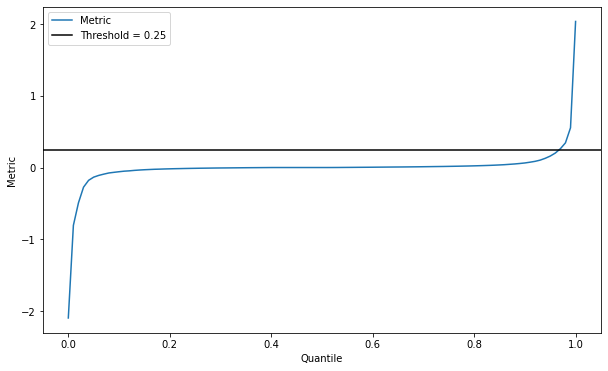

In [94]:
plt.figure(figsize=(10,6))
dflc_interest['mag_ewm_diff8_rolling4'].quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Metric')
plt.axhline(0.25, color='k', label='Threshold = 0.25')
plt.legend()
plt.show()

In [179]:
cand=pd.read_csv('ZTF19aanxwrq.csv')

In [180]:
cand['dc_mag_ulim'] = cand['diffmaglim'] #-2.5 * np.log10(10**(-0.4*cand['magnr']) + 10**(-0.4*cand['diffmaglim']))
# cand['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*cand['magnr']) - 10**(-0.4*cand['diffmaglim']))
cand['combined_mag_ulim'] = [cand.loc[ii, 'dc_mag_ulim'] if pd.isna(cand.loc[ii, 'dc_mag']) else cand.loc[ii, 'dc_mag'] for ii in cand.index]

In [189]:
cand['utc'] = pd.to_datetime(cand['utc'])

cand['ztf_object_id'] = 'ZTF19aanxwrq'

cand['jd'] = cand['mjd'] + 2400000

cand.set_index(['ztf_object_id', 'fid'], inplace=True)
cand = cand.sort_values('utc').sort_index()

In [190]:
cand['combined_ema8'] = cand.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='8 days', times=x['utc']).mean()).values
cand['combined_mag_ewm_diff8'] = cand['combined_mag_ulim'] - cand['combined_ema8']
cand['combined_mag_ewm_diff8_rolling4'] = cand.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

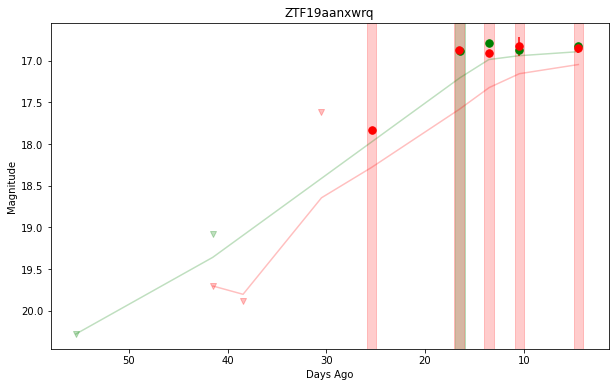

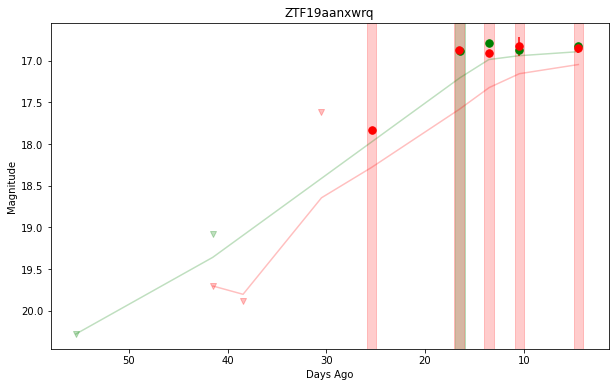

In [211]:

plot_dc_lightcurve_lim(cand2.reset_index(),'ZTF19aanxwrq', ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=770)

In [258]:
cand2 = cand.reset_index().sort_values('utc').iloc[:14]

In [259]:
cand3 = cand.reset_index().sort_values('utc').iloc[50:70]

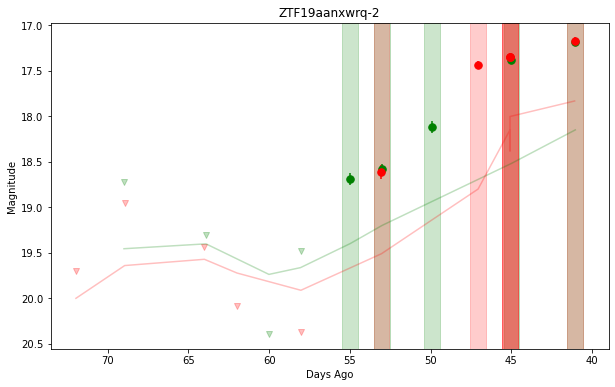

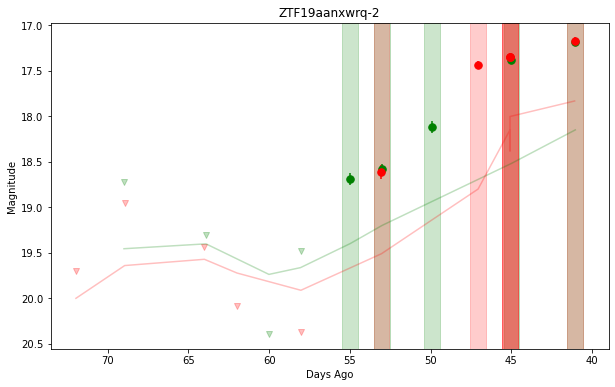

In [267]:
plot_dc_lightcurve_lim(cand3.reset_index(),'ZTF19aanxwrq-2', ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=0)

(58500.0, 58700.0)

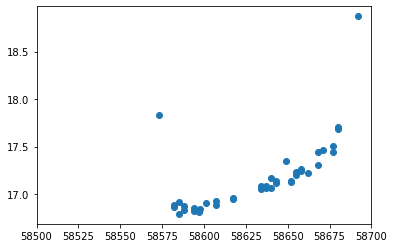

In [115]:
plt.scatter(cand['mjd'], cand['dc_mag'])
plt.xlim([58500, 58700])

In [156]:
cand.to_csv('ZTF19aanxwrq.csv', index=False)

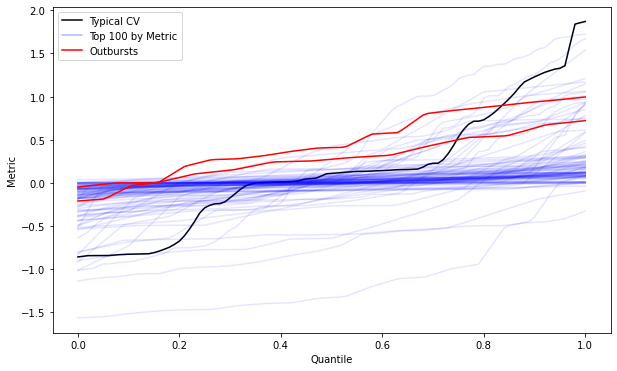

In [233]:
plt.figure(figsize=(10,6))

for i,x in enumerate(order_by_max[:100]):
    if i == 0:
        sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
        (-sub['mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', color='k', label='Typical CV')

    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
    (-sub['mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', color='b', alpha=.1, label='')

sub['mag_ewm_diff8_rolling4'].quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Top 100 by Metric', color='b', alpha=.3)
(-cand2['combined_mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Outbursts', color='red')
(-cand3['combined_mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='', color='red')
plt.legend()
plt.show()

In [ ]:
### Investigate distribution of metric

plt.figure(figsize=(10,6))
dflc_interest['mag_ewm_diff8_rolling4'].quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Metric')
plt.axhline(0.25, color='k', label='Threshold = 0.25')
plt.legend()
plt.show()

cand=pd.read_csv('ZTF19aanxwrq.csv')

cand['dc_mag_ulim'] = cand['diffmaglim'] #-2.5 * np.log10(10**(-0.4*cand['magnr']) + 10**(-0.4*cand['diffmaglim']))
# cand['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*cand['magnr']) - 10**(-0.4*cand['diffmaglim']))
cand['combined_mag_ulim'] = [cand.loc[ii, 'dc_mag_ulim'] if pd.isna(cand.loc[ii, 'dc_mag']) else cand.loc[ii, 'dc_mag'] for ii in cand.index]

cand['utc'] = pd.to_datetime(cand['utc'])

cand['ztf_object_id'] = 'ZTF19aanxwrq'

cand['jd'] = cand['mjd'] + 2400000

cand.set_index(['ztf_object_id', 'fid'], inplace=True)
cand = cand.sort_values('utc').sort_index()

cand['combined_ema8'] = cand.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='8 days', times=x['utc']).mean()).values
cand['combined_mag_ewm_diff8'] = cand['combined_mag_ulim'] - cand['combined_ema8']
cand['combined_mag_ewm_diff8_rolling4'] = cand.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values




plot_dc_lightcurve_lim(cand2.reset_index(),'ZTF19aanxwrq', ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=770)

cand2 = cand.reset_index().sort_values('utc').iloc[:14]

cand3 = cand.reset_index().sort_values('utc').iloc[50:70]

plot_dc_lightcurve_lim(cand3.reset_index(),'ZTF19aanxwrq-2', ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=0)

plt.scatter(cand['mjd'], cand['dc_mag'])
plt.xlim([58500, 58700])

cand.to_csv('ZTF19aanxwrq.csv', index=False)

plt.figure(figsize=(10,6))

for i,x in enumerate(order_by_max[:100]):
    if i == 0:
        sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
        (-sub['mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', color='k', label='Typical CV')

    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
    (-sub['mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', color='b', alpha=.1, label='')

sub['mag_ewm_diff8_rolling4'].quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Top 100 by Metric', color='b', alpha=.3)
(-cand2['combined_mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='Outbursts', color='red')
(-cand3['combined_mag_ewm_diff8_rolling4']).quantile(np.linspace(0, 1, 101)).plot(xlabel='Quantile', ylabel='Metric', label='', color='red')
plt.legend()
plt.show()

In [260]:
cand2['ztf_object_id'] = 'ZTF19aanxwrq-1'
cand3['ztf_object_id'] = 'ZTF19aanxwrq-2'

In [261]:
cand2.set_index(['ztf_object_id', 'fid'], inplace=True)
cand3.set_index(['ztf_object_id', 'fid'], inplace=True)

In [270]:
injection_recent = pd.concat([recent, cand2, cand3])

In [317]:
combined_order_by_max = injection_recent.groupby("ztf_object_id")['combined_mag_ewm_diff8_rolling4'].apply(lambda x: x.abs().max()).sort_values(ascending=False).index

In [264]:
injection_dflc_interest_new = pd.concat([dflc_interest_new, cand2, cand3])

In [274]:
len(combined_order_by_max)

369